In [1]:
using Pkg
if isfile("Project.toml") && isfile("Manifest.toml")
    Pkg.activate(".")
end

# Init Bionic VTOL

In [2]:
include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

using TensorBoardLogger
using Logging

using BSON: @save, @load # save mode

In [3]:
# TODO: set as desired
R_TOL = 0.5;
N_WAYPOINTS = 4; # including startpoint, >= 2
SLOW_MODE = true;
TRAINING = true;
EVALUATION = true;
VIDEO = false;

In [4]:
create_remote_visualization();

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://10.183.60.226:8700


In [5]:
# TensorBoard
logger = TBLogger("tensorboard_SAC", tb_increment)

TBLogger:
	- Log level     : Info
	- Current step  : 0
	- Output        : /home/larissa/Documents/Projects/ADLR/ADLR_project/src/RL_SAC_quadcopter_3D/tensorboard_SAC_4
	- open files    : 1


In [6]:
# indicates how many threads Julia was started with. This is important for the multi-threaded environment
Threads.nthreads()

1

In [7]:
Δt = 0.025;

# Create Reinforcement Learning Environment

In [8]:
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv # Parametric Constructor for a subtype of AbstractEnv
    action_space::A # All possible actions the agent can take
    observation_space::Space{Vector{ClosedInterval{T}}} # All possible states that the agent can observe.
    state::Vector{T} # Current state
    action::ACT # next action the agent wants to apply in the environment.
    done::Bool # shows whether a terminal condition has been reached.
    t::T # time
    rng::R # random number generator

    name::String # for different naming of multible environoments
    visualization::Bool # activate visualisation (Faster computation without visualisation)
    realtime::Bool # visualization in "real-world" time (only for watching or filming).
    
    # Overall state of the environment. This does not correspond to the observation space of the agent but contains all states that describe the environment.
    x_W::Vector{T} # Position in World frame
    v_B::Vector{T} # Velocity in Body frame
    R_W::Matrix{T} # Rotation (matrix) in World frame
    ω_B::Vector{T} # Rotation velocity in Body frame
    wind_W::Vector{T} # Externel linear velocity acting on the drone
    Δt::T # Time step for physics simulation in seconds

    ###NEW###
    # Current Bonus / Target
    num_waypoints::Int # includig start point
    waypoints::Vector{Vector{T}}
    reached_goal::BitVector
    
    norm_way::T
    progress::T
    progress_prev::T
    current_point::Int
    reached_goal_in_step::Bool
    
    r_tol::T
    projected_position::Vector{T}

    slow_mode::Bool
    ######
end

In [9]:
# define a keyword-based constructor for the type declared in the mutable struct typedef. 
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
    rng = Random.GLOBAL_RNG, # Random number generation
    name = "Crazyflie",
    visualization = false,
    realtime = false,
    kwargs... # let the function take an arbitrary number of keyword arguments
)
    
    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.
    
    # final PWM Values for Crazyflie. The interval definition has no effect in the current implementation.
    action_space = Space(
        ClosedInterval{T}[
            0..1#0..65535, # motor 1
            0..1#0..65535, # motor 2
            0..1#0..65535, # motor 3
            0..1#0..65535, # motor 4
            ], 
    )

    
    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[#todo
            typemin(T)..typemax(T), # 1 x
            typemin(T)..typemax(T), # 2 y
            typemin(T)..typemax(T), # 3 z

            typemin(T)..typemax(T), # 4  World Vector UP x
            typemin(T)..typemax(T), # 5  World Vector UP y
            typemin(T)..typemax(T), # 6  World Vector UP z

            typemin(T)..typemax(T), # 7  World Vector FRONT x
            typemin(T)..typemax(T), # 8  World Vector FRONT y
            typemin(T)..typemax(T), # 9  World Vector FRONT z
            
            typemin(T)..typemax(T), # 10 Body velocity along x
            typemin(T)..typemax(T), # 11 Body velocity along y
            typemin(T)..typemax(T), # 12 Body velocity along z
            
            typemin(T)..typemax(T), # 13 Body rotational velocity around x
            typemin(T)..typemax(T), # 14 Body rotational velocity around y
            typemin(T)..typemax(T), # 15 Body rotational velocity around z
            
            ###NEW###
            typemin(T)..typemax(T), # 16 position error along x (next gate - current position)
            typemin(T)..typemax(T), # 17 position error along y (next gate - current position)
            typemin(T)..typemax(T), # 18 position error along z (next gate - current position)
            
            typemin(T)..typemax(T), # 19 way to next next gate x (next next gate - next gate)
            typemin(T)..typemax(T), # 20 way to next next gate y (next next gate - next gate)
            typemin(T)..typemax(T), # 21 way to next next gate z (next next gate - next gate)
            ######
            ], 
    )

    ###NEW###
    num_waypoints = N_WAYPOINTS # number of waypoints, includig start point
    waypoints = generate_trajectory(num_waypoints + 1) # trajectory with num_waypoints waypoints (+ start point), (with dummy points) 
    reached_goal = falses(num_waypoints)
    
    norm_way = 0.0 
    for i in 1:(num_waypoints - 1)
        norm_way += norm(waypoints[i] - waypoints[i + 1])
    end
    ######
    
    if visualization
        create_Crazyflie(name, actuators = true);
        visualize_waypoints(waypoints[1:num_waypoints], 0.05)

        set_Crazyflie_actuators(name, [0.0; 0.0; 0.0; 0.0]);
        set_transform(name, [0.0; 0.0; 0.0] ,one(QuatRotation));
        set_arrow(string(name, "vel"), color_vec=[0.0; 1.0; 0.0; 1.0]);
        transform_arrow(string(name, "vel"), [0.0; 0.0; 0.0], [0.0; 0.0; 1.0], max_head_radius=0.05)
#         set_arrow(string(name, "_vel_current"), color_vec=[1.0; 0.0; 0.0; 1.0]);
#         transform_arrow(string(name, "_vel_current"), [0.0; 0.0; 0.0], [0.0; 0.0; 1.0], max_head_radius=0.02)                  
    end
    


    environment = VtolEnv(
        action_space,
        state_space,
        zeros(T, length(state_space)), # current state, needs to be extended.
        [0.25; 0.25; 0.25; 0.25],#rand(action_space), #todo test with random
        false, # episode done ?
        0.0, # time
        rng, # random number generator  

        name,
        visualization,
        realtime,

        zeros(T, 3), # x_W
        zeros(T, 3), # v_B
        Matrix(one(QuatRotation)), # Float64... so T needs to be Float64
        zeros(T, 3), # ω_B
        zeros(T, 3), # wind_W
        Δt, # Δt

        num_waypoints, # includig start point
        waypoints, 
        reached_goal,

        norm_way, # norm_way
        0.0, # progress
        0.0, # progress_prev
        2, # current point
        false, # reached_goal_in_step
        
        R_TOL, # r_tol
        zeros(T, 3), # projected_position

        SLOW_MODE # slow_mode

        )
    
    
    RLBase.reset!(environment)
    
    return environment
    
end;

Just for explanation:

1. A mutable Struct is created. A struct is a constructor and a constructor is a function that creates new objects.
2. A outer keyword-based constructor method is added for the type declared in the mutable struct typedef before.

So now we have a function with two methods. Julia will decide which method to call by multiple dispatch.

# Define the RL interface

In [10]:
Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

In [11]:
function scale_for_slowmode(slow_mode::Bool, v_min::T, v_max::T, d_max::T, x_W::Vector{T}, projected_position::Vector{T}, v_B::Vector{T}) where T
    
    if slow_mode == false
        return 1
    else
        if norm(v_B) > v_max
            s_vmax = 10^(v_max - norm(v_B))
        else
            s_vmax = 1
        end

        if norm(v_B) < v_min
            s_vmin = 10^(norm(v_B) - v_min)
        else
            s_vmin = 1
        end

        if norm(x_W - projected_position) > d_max
            s_gd = exp(-norm(x_W - projected_position) + d_max)
        else
            s_gd = 1
        end
        s = s_vmax * s_vmin * s_gd
    end
    return s
end;

In [12]:
function computeReward(env::VtolEnv{A,T}) where {A,T}
    
    
    if env.slow_mode
        v_min = 1.0 # min velocity
        v_max = 3.0 # max velocity
        d_max = 0.5 
    else
        v_min = 4.0 # min velocity
        v_max = 50.0 # max velocity
        d_max = 1.0 
    end


    s = scale_for_slowmode(true, v_min, v_max, d_max, env.x_W, env.projected_position, env.v_B)
    
    # TODO: test norming
    k_p = 5.0 * s #/ env.norm_way # factor for progress (between current position and last position) reward 
    r_p = (env.progress - env.progress_prev); # reward for progress (between current position and last position)

    k_s = s * (2 * v_max * env.Δt) / env.norm_way # factor for reached distance (overall) reward
    r_s = env.progress # reward for reached distance (overall)
    
    k_wp = 50.0 # factor for reached gate reward
    r_wp = 0.0 # reward for reached gate
    if env.reached_goal_in_step
        r_wp = exp(-norm(env.x_W - env.waypoints[env.current_point - 1])/env.r_tol)
    end 

    # factor for too high body rate penalty
    if env.slow_mode
        k_ω = 0.01
    else
        k_ω = 0.001
    end
    #norm_ω = norm(env.ω_B[3]) # penalty for body rate
    norm_ω = norm(env.ω_B) # penalty for body rate

    if env.x_W[3] < 0
        fall = 1
    else
        fall = 0
    end
    
    if !env.slow_mode
        k_s /= env.norm_way
        k_p /= env.norm_way
    end
    
    return k_p * r_p + k_s * r_s + k_wp * r_wp - k_ω * norm_ω - fall
    
end


RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

In [13]:
function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    
    env.x_W = [0.0; 0.0; 0.0];
    env.v_B = [0.0; 0.0; 0.0];
    env.R_W = Matrix(one(QuatRotation)); # Identity matrix (no rotation)
    env.ω_B = [0.0; 0.0; 0.0];
    env.wind_W = [0.0; 0.0; 0.0];


    env.waypoints = generate_trajectory(env.num_waypoints + 1); # Dummy points
    env.reached_goal = falses(env.num_waypoints);
    env.reached_goal[1] = true; # set first point to reached (start point)
    
    env.current_point = 2;
    env.reached_goal_in_step = false;
    #env.r_tol = 0.3;
    
    if env.visualization
        visualize_waypoints(env.waypoints[1:env.num_waypoints], 0.05); 
    end
    
    norm_way = 0.0 
    for i in 1:(env.num_waypoints - 1)
        norm_way += norm(env.waypoints[i] - env.waypoints[i + 1])
    end
    
    env.norm_way = norm_way
    env.progress = 0.0;
    env.progress_prev = 0.0;
        
 #todo
    env.state = [env.x_W[1]; # 1 position along x
                 env.x_W[2]; # 2 position along y
                 env.x_W[3]; # 3 position along z
#todo right R_W?
                 env.R_W[1,1];
                 env.R_W[2,1];
                 env.R_W[3,1];
        
                 env.R_W[1,3]; # 4  World Vector UP x
                 env.R_W[2,3]; # 5  World Vector UP y
                 env.R_W[3,3]; # 6  World Vector UP z

#                  env.R_W[1,1]; # 7  World Vector FRONT x
#                  env.R_W[2,1]; # 8  World Vector FRONT y
#                  env.R_W[3,1]; # 9  World Vector FRONT z

                 env.v_B[1]; #  10 Body velocity along x
                 env.v_B[2]; #  11 Body velocity along y
                 env.v_B[3]; #  12 Body velocity along z

                 env.ω_B[1]; #  13  Body rotational velocity around x
                 env.ω_B[2]; #  14  Body rotational velocity around y
                 env.ω_B[3]; #  15  Body rotational velocity around z

                 env.waypoints[2][1] - env.x_W[1]; # 16 position error to next gate along x
                 env.waypoints[2][2] - env.x_W[2]; # 17 position error to next gate along z
                 env.waypoints[2][3] - env.x_W[3]; # 18 position error to next gate along z
                 
                 env.waypoints[3][1] - env.waypoints[2][1]; # 19 way to next next gate x 
                 env.waypoints[3][2] - env.waypoints[2][2]; # 20 way to next next gate y
                 env.waypoints[3][3] - env.waypoints[2][3]]  # 21 way to next next gate z 
    

    env.t = 0.0; # time 0s
    env.action = [0.25; 0.25; 0.25; 0.25] # normalized # todo try with 0.0
    #env.last_action = [0.255; 0.255; 0.255; 0.255] # normalized
    #env.current_action = [0.255; 0.255; 0.255; 0.255] # normalized

    env.done = false # reset termination

    env.projected_position = [0; 0; 0]
    
    if env.visualization
        # Visualize initial state
        set_transform(env.name, env.x_W,QuatRotation(env.R_W));
        set_Crazyflie_actuators(env.name, [0.0; 0.0; 0.0; 0.0]);
        #transform_arrow(string(env.name, "_vel"), env.x_W, env.v_W_target, max_head_radius=0.05) 
        transform_arrow(string(env.name, "vel"), env.x_W, [0.0; 0.0; 0.0], max_head_radius=0.05) 
    end
    
    nothing # return nothing
end;

In [14]:
# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
function (env::VtolEnv)(a)


    # call the step on the environoment with the next action 
    _step!(env, a)
        
end

In [15]:
env = VtolEnv();

In [16]:
methods(env) # Just to explain which methods the object has

# 3 methods for callable object:
[1] (env::VtolEnv)(a) in Main at In[14]:3
[2] (env::AbstractEnv)(action) in ReinforcementLearningBase
[3] (env::AbstractEnv)(action, player) in ReinforcementLearningBase

In [17]:
function scale_actions(next_action)
    return next_action*22000.0
end

scale_actions (generic function with 1 method)

In [18]:
function _step!(env::VtolEnv, next_action)
    

    #env.last_action = copy(env.current_action)
    #env.current_action[1] = next_action[1]
    #env.current_action[2] = next_action[2]
    #env.current_action[3] = next_action[3]
    #env.current_action[4] = next_action[4]
    
    
    
    scaled_actions = scale_actions.(next_action) # between 0 and 1 for neual network
    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W)
    # caluclate aerodynamic forces
    torque_B, force_B = crazyflie_model(scaled_actions);
    # integrate rigid body dynamics for Δt
    env.x_W, env.v_B, env.R_W, env.ω_B, env.t = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.ω_B, env.t, env.Δt, crazyflie_param)

    
    env.reached_goal_in_step = false;
    if norm(env.x_W - env.waypoints[env.current_point]) < env.r_tol
        env.reached_goal_in_step = true;
        env.reached_goal[env.current_point] = true;
        env.current_point += 1;
    end
        
            
    # calculate progress on trajectory
    env.progress_prev = env.progress
    
    current_progress = 0.0
    line_segment, env.projected_position = calculate_progress(env.waypoints, env.x_W)
    
    #env.current_point = line_segment + 1

    for i in 2:(line_segment)
       current_progress +=  norm(env.waypoints[i] - env.waypoints[i - 1])  
    end
    current_progress += norm(env.waypoints[line_segment] - env.projected_position)
    
    env.progress = current_progress
    

    if env.realtime
        sleep(env.Δt) # TODO: just a dirty hack. this is of course slower than real time.
    end

    # env.t += env.Δt # todo reevaluate


    if env.visualization
        set_transform(env.name, env.x_W,QuatRotation(env.R_W));
        set_Crazyflie_actuators(env.name, next_action[1:4])
        #transform_arrow(string(env.name, "_vel"), env.x_W, env.v_W_target, max_head_radius=0.05)               
        transform_arrow(string(env.name, "vel"), env.x_W, env.R_W*env.v_B, max_head_radius=0.05) 
    
        for i in eachindex(env.reached_goal)
            if env.reached_goal[i]
                create_sphere("fixgoal_$i", 0.05, color=RGBA{Float32}(1.0, 0.0, 0.0, 1.0));
                set_transform("fixgoal_$i", env.waypoints[i]);
            end
        end

    end
    
    
    #v_B_target = transpose(env.R_W)*env.v_W_target
    
    
    # State space
    #todo
    env.state[1] = env.x_W[1];
    env.state[2] = env.x_W[2];
    env.state[3] = env.x_W[3];
    
    env.state[4] = env.R_W[1,1] # 1  World Vector UP x
    env.state[5] = env.R_W[2,1] # 2  World Vector UP y
    env.state[6] = env.R_W[3,1] # 3  World Vector UP z

    env.state[7] = env.R_W[1,3] # 4  World Vector FRONT x
    env.state[8] = env.R_W[2,3] # 5  World Vector FRONT y
    env.state[9] = env.R_W[3,3] # 6  World Vector FRONT z
        
    env.state[10] = env.v_B[1] # 7  Body velocity along x
    env.state[11] = env.v_B[2] # 8  Body velocity along y
    env.state[12] = env.v_B[3] # 9  Body velocity along z

    env.state[13] = env.ω_B[1] # 10 Body rotational velocity around x
    env.state[14] = env.ω_B[2] # 11 Body rotational velocity around y
    env.state[15] = env.ω_B[3] # 12 Body rotational velocity around z

    env.state[16] = env.waypoints[env.current_point][1] - env.x_W[1] # 13 position error to next gate along x
    env.state[17] = env.waypoints[env.current_point][2] - env.x_W[2]; # 14 position error to next gate along z
    env.state[18] = env.waypoints[env.current_point][3] - env.x_W[3]; # 15 position error to next gate along z
     #todo            
    if env.current_point <= env.num_waypoints
        env.state[19] = env.waypoints[env.current_point + 1][1] - env.waypoints[env.current_point][1] ; # 16 way to next next gate x (next next gate - next gate), dummy integriert
        env.state[20] = env.waypoints[env.current_point + 1][2] - env.waypoints[env.current_point][2]; # 17 way to next next gate y (next next gate - next gate), dummy integriert
        env.state[21] = env.waypoints[env.current_point + 1][3] - env.waypoints[env.current_point][3]; # 18 way to next next gate z (next next gate - next gate), dummy integriert
    end

    
    
    # Termination criteria
    env.done = #true
        # After time... How fast is drone+Range of desired point
        # After reaching position (circle of r_tol)
         norm(env.ω_B) > 100.0 || 
         norm(env.v_B) > 100.0 || # stop if body is too fast_point 
        env.x_W[3] < -1.0 || # stop if body is below -5m
        env.t > env.num_waypoints * 3.0 ||# stop after 3s per point #todo set in fast learning phase
        norm(env.x_W - env.projected_position) > 5.0 || # too far off the path 
        env.reached_goal == trues(env.num_waypoints)

    nothing
end;

In [19]:
RLBase.test_runnable!(env)

Test Summary:              | Pass  Total  Time
random policy with VtolEnv | 2000   2000  2.8s


Test.DefaultTestSet("random policy with VtolEnv", Any[], 2000, false, false, true, 1.67688947109684e9, 1.676889473882697e9)

Show an overview of the environment.

# Setup of a reinforcement learning experiment.

In [20]:
seed = 123    
rng = StableRNG(seed)
#N_ENV = 8 # TODO 1 environment
UPDATE_FREQ = 2048
EVALUATION_FREQ = 10_000
SAVE_FREQ = 100_000

# define multiple environments for parallel training
env = VtolEnv(; rng = StableRNG(hash(seed)), name = "cf_SAC") 

# VtolEnv

## Traits

| Trait Type        |                  Value |
|:----------------- | ----------------------:|
| NumAgentStyle     |          SingleAgent() |
| DynamicStyle      |           Sequential() |
| InformationStyle  | ImperfectInformation() |
| ChanceStyle       |           Stochastic() |
| RewardStyle       |           StepReward() |
| UtilityStyle      |           GeneralSum() |
| ActionStyle       |     MinimalActionSet() |
| StateStyle        |     Observation{Any}() |
| DefaultStateStyle |     Observation{Any}() |

## Is Environment Terminated?

No

## State Space

`Space{Vector{ClosedInterval{Float64}}}(ClosedInterval{Float64}[-Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf])`

## Action Space

`Space{Vector{ClosedInterval{Float64}}}(ClosedInterval{Float64}[0.0..1.0, 0.0..1.0, 0.0..1.0, 0.0..1.0])`

## Current State

```
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.170879518051267, -2.7772226734713055, 1.332242604207609, -1.6809010824262567, 2.095002283427654, 1.8235068733348776]
```


In [21]:
# Define the function approximator
# TODO ?
    ns, na = length(state(env)), length(action_space(env))

create_policy_net() = NeuralNetworkApproximator(
        model = GaussianNetwork(
            pre = Chain(
                Dense(ns, 256, tanh, init = glorot_uniform(rng)),
                Dense(256, 256, tanh, init = glorot_uniform(rng)),
            ),
            μ = Chain(Dense(256, na, init = glorot_uniform(rng))),
            logσ = Chain(Dense(256, na, x -> clamp.(x, typeof(x)(-10), typeof(x)(2)), init = glorot_uniform(rng))),
        ),
        optimizer = ADAM(1e-4),
    )

create_q_net() = NeuralNetworkApproximator(
        model = Chain(
            Dense(ns + na, 256, tanh; init = glorot_uniform(rng)),
            Dense(256, 256, tanh; init = glorot_uniform(rng)),
            Dense(256, 1; init = glorot_uniform(rng)),
        ),
        optimizer = ADAM(1e-4),
    )

create_q_net (generic function with 1 method)

In [22]:
dataset_size = 100_000_000
start_steps = dataset_size # puffer size
trajectory_num = dataset_size
#TODO ? 

100000000

In [23]:
    agent = Agent( # A wrapper of an AbstractPolicy
     # TODO ?    
    
    policy = SACPolicy(
            policy = create_policy_net(),
            qnetwork1 = create_q_net(),
            qnetwork2 = create_q_net(),
            #target_qnetwork1 = create_q_net(),
            #target_qnetwork2 = create_q_net(),
            γ = 0.99f0,
            τ = 0.005f0,
            α = 0.2f0,
            batch_size = 256,
            start_steps = start_steps,
            start_policy = RandomPolicy(Space([-1.0..1.0 for _ in 1:na]); rng = rng),
            update_after = start_steps,
            update_freq = UPDATE_FREQ,
            automatic_entropy_tuning = true,
            lr_alpha = 0.003f0,
            action_dims = na,
            rng = rng,
        ),
        trajectory = CircularArraySARTTrajectory(
            capacity = dataset_size+1,
            state = Vector{Float32} => (ns,),
            action = Vector{Float32} => (na,),
        ),

    
    );






In [24]:
function saveModel(t, agent, env)
    model = cpu(agent.policy)  
    if SLOW_MODE
        f = joinpath("./RL_models_slow/", "cf_sac_$t.bson")
    else
        f = joinpath("./RL_models_fast/", "cf_sac_$t.bson")
    end;
    @save f model
    println("parameters at step $t saved to $f")
end

saveModel (generic function with 1 method)

In [25]:
function loadModel()
    f = joinpath("./RL_models_slow/", "cf_sac_$(load_from_slow_step).bson")
    @load f model
    return model
end

loadModel (generic function with 1 method)

In [26]:
function validate_policy(t, agent, env)
    # for validation extract the policy from the agend
    run(agent.policy, test_env, StopAfterEpisode(1), 
        ComposedHook(
        episode_test_step_hook, 
        episode_test_reward_hook
    ),
        )
    # the result of the hook
    reward = round((episode_test_reward_hook.rewards[end]),digits = 3)
    length = episode_test_step_hook.steps[end-1]
    
    println("step: ", t, " reward : ",reward, " length: ", length)

    with_logger(logger) do
        @info "evaluating" avg_length = length  avg_reward = reward  log_step_increment = 0
    end
    end;

episode_test_reward_hook = TotalRewardPerEpisode( is_display_on_exit=false)
episode_test_step_hook = StepsPerEpisode()
# create a env only for reward test

test_env = VtolEnv(;name = "test_cf", visualization = true, worldtime = true);

In [27]:
# number of steps
steps_slow = 20_000_000
steps_fast = 20_000_000
load_from_slow_step = 20_000_000 # TODO: choose slow model

save_freq = 100_000
validate_freq = 100_000

steps = 0
if SLOW_MODE
    steps = steps_slow
else
    steps = steps_fast
end

20000000

In [28]:
# Define hook which is called during the training
total_reward_per_episode = TotalRewardPerEpisode(is_display_on_exit = false)
hook = ComposedHook(
    #total_batch_reward_per_episode,
    DoEveryNStep(saveModel, n=SAVE_FREQ),
    DoEveryNStep(validate_policy, n=EVALUATION_FREQ),
    #=
    DoEveryNStep() do t, agent, env
        p = agent.policy
        with_logger(logger) do
            @info "training" loss = mean(p.loss)  actor_loss = mean(p.actor_loss)  critic_loss = mean(p.critic_loss)
        end
    end,
    =#
    DoEveryNStep() do t, agent, env
        with_logger(logger) do
            if length(total_reward_per_episode.rewards) > 1
                @info "training" total_reward_per_episode.rewards[end]
            end
        end
    end,
    #=
    DoEveryNStep() do t, agent, env
        with_logger(logger) do
            @info "training" action_thrust_1 = env[1].action[1]  action_thrust_2 = env[1].action[2] action_thrust_3 = env[1].action[3] action_thrust_4 = env[1].action[4]
        end
    end,
    =#
);

In [29]:
#todo load model
if !SLOW_MODE
    agent.policy.approximator = loadModel(); 
end;

In [30]:
if TRAINING
    ReinforcementLearning.run(
        agent,
        env,
        StopAfterStep(steps),
        hook
    )
end

Progress:   0%|                                         |  ETA: 635.19 days

step: 10000 reward : -20.243 length: 19


Progress:   0%|                                         |  ETA: 5:35:16

step: 20000 reward : -19.555 length: 19
step: 30000 reward : -19.384 length: 19
step: 40000 reward : -20.717 length: 19
step: 50000 reward : -19.685 length: 19


Progress:   0%|▏                                        |  ETA: 1:10:01

step: 60000 reward : -19.799 length: 19
step: 70000 reward : -19.881 length: 19
step: 80000 reward : -20.059 length: 19
step: 90000 reward : -20.847 length: 19


Progress:   0%|▎                                        |  ETA: 0:43:36

parameters at step 100000 saved to ./RL_models_slow/cf_sac_100000.bson
step: 100000 reward : -20.239 length: 19
step: 110000 reward : -19.928 length: 19
step: 120000 reward : -19.857 length: 19


Progress:   1%|▎                                        |  ETA: 0:47:25

step: 130000 reward : -19.806 length: 19
step: 140000 reward : -20.009 length: 19
step: 150000 reward : -19.745 length: 19
step: 160000 reward : -20.361 length: 19
step: 170000 reward : -20.454 length: 19


Progress:   1%|▍                                        |  ETA: 0:37:26

step: 180000 reward : -20.359 length: 19
step: 190000 reward : -20.222 length: 19
parameters at step 200000 saved to ./RL_models_slow/cf_sac_200000.bson
step: 200000 reward : -20.009 length: 19
step: 210000 reward : -20.235 length: 19


Progress:   1%|▌                                        |  ETA: 0:32:40

step: 220000 reward : -20.656 length: 19
step: 230000 reward : -20.63 length: 19
step: 240000 reward : -19.914 length: 19
step: 250000 reward : -20.113 length: 19
step: 260000 reward : -20.706 length: 19


Progress:   1%|▌                                        |  ETA: 0:28:19

step: 270000 reward : -19.498 length: 19
step: 280000 reward : -20.357 length: 19
step: 290000 reward : -20.8 length: 19
parameters at step 300000 saved to ./RL_models_slow/cf_sac_300000.bson
step: 300000 reward : -20.561 length: 19


Progress:   2%|▋                                        |  ETA: 0:25:19

step: 310000 reward : -20.088 length: 19
step: 320000 reward : -20.148 length: 19
step: 330000 reward : -19.933 length: 19
step: 340000 reward : -20.272 length: 19


Progress:   2%|▊                                        |  ETA: 0:23:12

step: 350000 reward : -19.84 length: 19
step: 360000 reward : -19.857 length: 19
step: 370000 reward : -20.473 length: 19
step: 380000 reward : -19.778 length: 18
step: 390000 reward : -19.969 length: 19


Progress:   2%|▊                                        |  ETA: 0:21:24

parameters at step 400000 saved to ./RL_models_slow/cf_sac_400000.bson
step: 400000 reward : -20.362 length: 19
step: 410000 reward : -19.99 length: 19
step: 420000 reward : -20.784 length: 19
step: 430000 reward : -20.087 length: 19


Progress:   2%|▉                                        |  ETA: 0:20:00

step: 440000 reward : -20.248 length: 19
step: 450000 reward : -19.921 length: 19
step: 460000 reward : -19.969 length: 19
step: 470000 reward : -20.664 length: 19


Progress:   2%|█                                        |  ETA: 0:18:51

step: 480000 reward : -20.214 length: 19
step: 490000 reward : -19.781 length: 19
parameters at step 500000 saved to ./RL_models_slow/cf_sac_500000.bson
step: 500000 reward : -19.864 length: 19
step: 510000 reward : -20.027 length: 19
step: 520000 reward : -20.876 length: 19


Progress:   3%|█▏                                       |  ETA: 0:18:01

step: 530000 reward : -20.313 length: 19
step: 540000 reward : -19.805 length: 19
step: 550000 reward : -20.486 length: 19
step: 560000 reward : -20.518 length: 19


Progress:   3%|█▏                                       |  ETA: 0:17:15

step: 570000 reward : -20.093 length: 19
step: 580000 reward : -20.45 length: 19
step: 590000 reward : -19.606 length: 19
parameters at step 600000 saved to ./RL_models_slow/cf_sac_600000.bson
step: 600000 reward : -19.811 length: 19


Progress:   3%|█▎                                       |  ETA: 0:16:40

step: 610000 reward : -20.166 length: 19
step: 620000 reward : -20.163 length: 19
step: 630000 reward : -19.914 length: 19
step: 640000 reward : -19.695 length: 19


Progress:   3%|█▍                                       |  ETA: 0:16:14

step: 650000 reward : -20.6 length: 19
step: 660000 reward : -20.24 length: 19
step: 670000 reward : -20.247 length: 19


Progress:   3%|█▍                                       |  ETA: 0:15:51

step: 680000 reward : -20.16 length: 19
step: 690000 reward : -20.105 length: 19
parameters at step 700000 saved to ./RL_models_slow/cf_sac_700000.bson
step: 700000 reward : -20.934 length: 19
step: 710000 reward : -20.435 length: 19


Progress:   4%|█▌                                       |  ETA: 0:16:00

step: 720000 reward : -20.203 length: 19
step: 730000 reward : -20.812 length: 19
step: 740000 reward : -19.802 length: 19
step: 750000 reward : -21.561 length: 19


Progress:   4%|█▌                                       |  ETA: 0:15:27

step: 760000 reward : -19.458 length: 19
step: 770000 reward : -20.28 length: 19
step: 780000 reward : -19.82 length: 19
step: 790000 reward : -19.775 length: 19
parameters at step 800000 saved to ./RL_models_slow/cf_sac_800000.bson

Progress:   4%|█▋                                       |  ETA: 0:15:03


step: 800000 reward : -19.646 length: 19
step: 810000 reward : -20.585 length: 19
step: 820000 reward : -20.204 length: 19
step: 830000 reward : -20.53 length: 19
step: 840000 reward : -20.342 length: 19


Progress:   4%|█▊                                       |  ETA: 0:14:43

step: 850000 reward : -20.663 length: 19
step: 860000 reward : -20.066 length: 19
step: 870000 reward : -19.708 length: 19
step: 880000 reward : -19.778 length: 19


Progress:   4%|█▉                                       |  ETA: 0:14:17

step: 890000 reward : -20.069 length: 19
parameters at step 900000 saved to ./RL_models_slow/cf_sac_900000.bson
step: 900000 reward : -20.018 length: 19
step: 910000 reward : -19.916 length: 19
step: 920000 reward : -20.188 length: 19
step: 930000 reward : -19.888 length: 19


Progress:   5%|█▉                                       |  ETA: 0:13:59

step: 940000 reward : -19.649 length: 19
step: 950000 reward : -19.934 length: 19
step: 960000 reward : -19.559 length: 19


Progress:   5%|██                                       |  ETA: 0:13:45

step: 970000 reward : -19.94 length: 19
step: 980000 reward : -19.77 length: 19
step: 990000 reward : -19.558 length: 19
parameters at step 1000000 saved to ./RL_models_slow/cf_sac_1000000.bson
step: 1000000 reward : -20.034 length: 19


Progress:   5%|██▏                                      |  ETA: 0:13:34

step: 1010000 reward : -19.695 length: 19
step: 1020000 reward : -19.374 length: 19
step: 1030000 reward : -19.408 length: 19
step: 1040000 reward : -19.944 length: 19


Progress:   5%|██▏                                      |  ETA: 0:13:21

step: 1050000 reward : -19.309 length: 18
step: 1060000 reward : -19.854 length: 19
step: 1070000 reward : -20.245 length: 19
step: 1080000 reward : -19.763 length: 19


Progress:   5%|██▎                                      |  ETA: 0:13:08

step: 1090000 reward : -19.743 length: 19
parameters at step 1100000 saved to ./RL_models_slow/cf_sac_1100000.bson
step: 1100000 reward : -20.377 length: 19
step: 1110000 reward : -20.752 length: 19
step: 1120000 reward : -20.392 length: 19


Progress:   6%|██▎                                      |  ETA: 0:12:56

step: 1130000 reward : -20.391 length: 19
step: 1140000 reward : -19.665 length: 19
step: 1150000 reward : -20.237 length: 19


Progress:   6%|██▍                                      |  ETA: 0:13:02

step: 1160000 reward : -20.873 length: 19
step: 1170000 reward : -20.037 length: 19
step: 1180000 reward : -19.728 length: 19
step: 1190000 reward : -19.846 length: 19
parameters at step 1200000 saved to ./RL_models_slow/cf_sac_1200000.bson
step: 1200000 reward : -20.054 length: 19


Progress:   6%|██▌                                      |  ETA: 0:12:44

step: 1210000 reward : -20.568 length: 19
step: 1220000 reward : -19.95 length: 19
step: 1230000 reward : -20.33 length: 19
step: 1240000 reward : -19.687 length: 19
step: 1250000 reward : -20.66 length: 19


Progress:   6%|██▋                                      |  ETA: 0:12:30

step: 1260000 reward : -19.946 length: 19
step: 1270000 reward : -19.557 length: 19
step: 1280000 reward : -20.065 length: 19
step: 1290000 reward : -20.703 length: 19
parameters at step 1300000 saved to ./RL_models_slow/cf_sac_1300000.bson

Progress:   7%|██▋                                      |  ETA: 0:12:19


step: 1300000 reward : -20.628 length: 19
step: 1310000 reward : -20.311 length: 19
step: 1320000 reward : -20.271 length: 19
step: 1330000 reward : -19.498 length: 19
step: 1340000 reward : -20.212 length: 19


Progress:   7%|██▊                                      |  ETA: 0:12:06

step: 1350000 reward : -19.663 length: 19
step: 1360000 reward : -19.439 length: 19
step: 1370000 reward : -20.664 length: 19
step: 1380000 reward : -20.601 length: 19
step: 1390000 reward : -19.409 length: 19


Progress:   7%|██▉                                      |  ETA: 0:11:53

parameters at step 1400000 saved to ./RL_models_slow/cf_sac_1400000.bson
step: 1400000 reward : -19.923 length: 19
step: 1410000 reward : -19.97 length: 19
step: 1420000 reward : -20.422 length: 19
step: 1430000 reward : -19.758 length: 19


Progress:   7%|███                                      |  ETA: 0:11:43

step: 1440000 reward : -20.423 length: 19
step: 1450000 reward : -19.97 length: 19
step: 1460000 reward : -19.836 length: 19
step: 1470000 reward : -19.503 length: 19
step: 1480000 reward : -19.859 length: 19


Progress:   7%|███                                      |  ETA: 0:11:32

step: 1490000 reward : -20.324 length: 19
parameters at step 1500000 saved to ./RL_models_slow/cf_sac_1500000.bson
step: 1500000 reward : -20.758 length: 19
step: 1510000 reward : -20.233 length: 19
step: 1520000 reward : -20.457 length: 19


Progress:   8%|███▏                                     |  ETA: 0:11:24

step: 1530000 reward : -19.669 length: 19
step: 1540000 reward : -20.128 length: 19
step: 1550000 reward : -20.345 length: 19
step: 1560000 reward : -19.707 length: 19
step: 1570000 reward : -19.296 length: 19


Progress:   8%|███▎                                     |  ETA: 0:11:13

step: 1580000 reward : -19.695 length: 19
step: 1590000 reward : -20.722 length: 19
parameters at step 1600000 saved to ./RL_models_slow/cf_sac_1600000.bson
step: 1600000 reward : -19.666 length: 19
step: 1610000 reward : -20.246 length: 19
step: 1620000 reward : -20.191 length: 19


Progress:   8%|███▍                                     |  ETA: 0:11:04

step: 1630000 reward : -20.43 length: 19
step: 1640000 reward : -19.816 length: 19
step: 1650000 reward : -20.639 length: 19
step: 1660000 reward : -20.417 length: 19


Progress:   8%|███▍                                     |  ETA: 0:10:57

step: 1670000 reward : -19.413 length: 19
step: 1680000 reward : -19.597 length: 19
step: 1690000 reward : -19.921 length: 19
parameters at step 1700000 saved to ./RL_models_slow/cf_sac_1700000.bson
step: 1700000 reward : -19.825 length: 19


Progress:   9%|███▌                                     |  ETA: 0:10:50

step: 1710000 reward : -19.822 length: 19
step: 1720000 reward : -20.224 length: 19
step: 1730000 reward : -19.819 length: 19
step: 1740000 reward : -19.972 length: 19
step: 1750000 reward : -20.49 length: 19


Progress:   9%|███▋                                     |  ETA: 0:10:52

step: 1760000 reward : -19.713 length: 18
step: 1770000 reward : -19.989 length: 19
step: 1780000 reward : -20.118 length: 19
step: 1790000 reward : -21.454 length: 19
parameters at step 1800000 saved to ./RL_models_slow/cf_sac_1800000.bson
step: 1800000 reward : -20.141 length: 19


Progress:   9%|███▊                                     |  ETA: 0:10:43

step: 1810000 reward : -19.996 length: 19
step: 1820000 reward : -19.806 length: 19
step: 1830000 reward : -19.687 length: 19
step: 1840000 reward : -20.164 length: 19


Progress:   9%|███▊                                     |  ETA: 0:10:37

step: 1850000 reward : -20.104 length: 19
step: 1860000 reward : -20.889 length: 19
step: 1870000 reward : -19.503 length: 19
step: 1880000 reward : -19.476 length: 19


Progress:   9%|███▉                                     |  ETA: 0:10:32

step: 1890000 reward : -20.019 length: 19
parameters at step 1900000 saved to ./RL_models_slow/cf_sac_1900000.bson
step: 1900000 reward : -19.618 length: 19
step: 1910000 reward : -19.303 length: 19
step: 1920000 reward : -19.734 length: 19


Progress:  10%|████                                     |  ETA: 0:10:26

step: 1930000 reward : -19.661 length: 19
step: 1940000 reward : -19.817 length: 19
step: 1950000 reward : -19.73 length: 19
step: 1960000 reward : -19.897 length: 19
step: 1970000 reward : -19.52 length: 19


Progress:  10%|████                                     |  ETA: 0:10:21

step: 1980000 reward : -19.932 length: 19
step: 1990000 reward : -19.469 length: 19
parameters at step 2000000 saved to ./RL_models_slow/cf_sac_2000000.bson
step: 2000000 reward : -20.037 length: 19
step: 2010000 reward : -19.524 length: 19


Progress:  10%|████▏                                    |  ETA: 0:10:16

step: 2020000 reward : -20.113 length: 19
step: 2030000 reward : -20.319 length: 19
step: 2040000 reward : -20.387 length: 19
step: 2050000 reward : -20.672 length: 19


Progress:  10%|████▎                                    |  ETA: 0:10:12

step: 2060000 reward : -19.885 length: 19
step: 2070000 reward : -19.808 length: 19
step: 2080000 reward : -19.683 length: 19
step: 2090000 reward : -20.117 length: 19


Progress:  10%|████▎                                    |  ETA: 0:10:08

parameters at step 2100000 saved to ./RL_models_slow/cf_sac_2100000.bson
step: 2100000 reward : -19.843 length: 19
step: 2110000 reward : -19.757 length: 19
step: 2120000 reward : -19.471 length: 19
step: 2130000 reward : -19.651 length: 19


Progress:  11%|████▍                                    |  ETA: 0:10:04

step: 2140000 reward : -21.026 length: 19
step: 2150000 reward : -20.447 length: 19
step: 2160000 reward : -19.943 length: 19
step: 2170000 reward : -20.89 length: 19


Progress:  11%|████▌                                    |  ETA: 0:09:59

step: 2180000 reward : -19.611 length: 19
step: 2190000 reward : -20.514 length: 19
parameters at step 2200000 saved to ./RL_models_slow/cf_sac_2200000.bson
step: 2200000 reward : -20.693 length: 19
step: 2210000 reward : -20.264 length: 19


Progress:  11%|████▌                                    |  ETA: 0:09:55

step: 2220000 reward : -19.631 length: 19
step: 2230000 reward : -19.543 length: 19
step: 2240000 reward : -20.832 length: 19
step: 2250000 reward : -20.021 length: 19


Progress:  11%|████▋                                    |  ETA: 0:09:50

step: 2260000 reward : -19.952 length: 19
step: 2270000 reward : -19.686 length: 19
step: 2280000 reward : -20.611 length: 19
step: 2290000 reward : -19.546 length: 19
parameters at step 2300000 saved to ./RL_models_slow/cf_sac_2300000.bson

Progress:  12%|████▊                                    |  ETA: 0:09:47


step: 2300000 reward : -19.509 length: 19
step: 2310000 reward : -20.95 length: 19
step: 2320000 reward : -19.633 length: 19
step: 2330000 reward : -19.874 length: 19


Progress:  12%|████▊                                    |  ETA: 0:09:44

step: 2340000 reward : -19.708 length: 19
step: 2350000 reward : -19.833 length: 19
step: 2360000 reward : -19.599 length: 19
step: 2370000 reward : -20.154 length: 19


Progress:  12%|████▉                                    |  ETA: 0:09:45

step: 2380000 reward : -20.071 length: 19
step: 2390000 reward : -20.242 length: 19
parameters at step 2400000 saved to ./RL_models_slow/cf_sac_2400000.bson
step: 2400000 reward : -20.019 length: 19
step: 2410000 reward : -20.389 length: 19


Progress:  12%|█████                                    |  ETA: 0:09:42

step: 2420000 reward : -19.836 length: 19
step: 2430000 reward : -20.124 length: 19
step: 2440000 reward : -20.383 length: 19
step: 2450000 reward : -19.473 length: 19


Progress:  12%|█████                                    |  ETA: 0:09:40

step: 2460000 reward : -19.515 length: 19
step: 2470000 reward : -21.621 length: 19
step: 2480000 reward : -19.885 length: 19


Progress:  12%|█████▏                                   |  ETA: 0:09:37

step: 2490000 reward : -19.856 length: 19
parameters at step 2500000 saved to ./RL_models_slow/cf_sac_2500000.bson
step: 2500000 reward : -20.685 length: 19
step: 2510000 reward : -19.988 length: 19
step: 2520000 reward : -19.859 length: 19


Progress:  13%|█████▏                                   |  ETA: 0:09:34

step: 2530000 reward : -19.86 length: 19
step: 2540000 reward : -19.52 length: 19
step: 2550000 reward : -20.967 length: 19
step: 2560000 reward : -20.034 length: 19


Progress:  13%|█████▎                                   |  ETA: 0:09:31

step: 2570000 reward : -19.91 length: 19
step: 2580000 reward : -19.974 length: 19
step: 2590000 reward : -20.569 length: 19
parameters at step 2600000 saved to ./RL_models_slow/cf_sac_2600000.bson
step: 2600000 reward : -19.877 length: 19


Progress:  13%|█████▍                                   |  ETA: 0:09:27

step: 2610000 reward : -20.489 length: 19
step: 2620000 reward : -19.873 length: 19
step: 2630000 reward : -20.86 length: 19
step: 2640000 reward : -19.674 length: 19
step: 2650000 reward : -19.783 length: 19


Progress:  13%|█████▌                                   |  ETA: 0:09:23

step: 2660000 reward : -20.584 length: 20
step: 2670000 reward : -19.628 length: 19
step: 2680000 reward : -19.502 length: 19
step: 2690000 reward : -19.87 length: 19
parameters at step 2700000 saved to ./RL_models_slow/cf_sac_2700000.bson
step: 2700000 reward : -20.734 length: 19


Progress:  14%|█████▌                                   |  ETA: 0:09:17

step: 2710000 reward : -20.257 length: 19
step: 2720000 reward : -20.413 length: 19
step: 2730000 reward : -21.134 length: 19
step: 2740000 reward : -19.85 length: 19


Progress:  14%|█████▋                                   |  ETA: 0:09:14

step: 2750000 reward : -19.779 length: 19
step: 2760000 reward : -19.819 length: 19
step: 2770000 reward : -20.891 length: 19
step: 2780000 reward : -20.073 length: 19
step: 2790000 reward : -21.616 length: 19


Progress:  14%|█████▊                                   |  ETA: 0:09:09

parameters at step 2800000 saved to ./RL_models_slow/cf_sac_2800000.bson
step: 2800000 reward : -20.064 length: 19
step: 2810000 reward : -19.998 length: 19
step: 2820000 reward : -20.09 length: 19
step: 2830000 reward : -19.861 length: 19
step: 2840000 reward : -20.252 length: 19


Progress:  14%|█████▉                                   |  ETA: 0:09:05

step: 2850000 reward : -19.699 length: 19
step: 2860000 reward : -19.845 length: 19
step: 2870000 reward : -19.344 length: 19
step: 2880000 reward : -20.506 length: 19


Progress:  14%|█████▉                                   |  ETA: 0:09:00

step: 2890000 reward : -20.458 length: 19
parameters at step 2900000 saved to ./RL_models_slow/cf_sac_2900000.bson
step: 2900000 reward : -19.518 length: 19
step: 2910000 reward : -20.872 length: 19
step: 2920000 reward : -20.031 length: 19
step: 2930000 reward : -19.655 length: 19
step: 2940000 reward : -20.121 length: 19


Progress:  15%|██████                                   |  ETA: 0:09:01

step: 2950000 reward : -21.226 length: 19
step: 2960000 reward : -19.632 length: 19
step: 2970000 reward : -19.517 length: 19
step: 2980000 reward : -20.058 length: 19
step: 2990000 reward : -19.947 length: 19


Progress:  15%|██████▏                                  |  ETA: 0:08:56

parameters at step 3000000 saved to ./RL_models_slow/cf_sac_3000000.bson
step: 3000000 reward : -20.157 length: 19
step: 3010000 reward : -19.741 length: 19
step: 3020000 reward : -20.438 length: 19
step: 3030000 reward : -20.134 length: 19
step: 3040000 reward : -20.093 length: 19


Progress:  15%|██████▎                                  |  ETA: 0:08:52

step: 3050000 reward : -20.886 length: 19
step: 3060000 reward : -20.571 length: 20
step: 3070000 reward : -19.932 length: 19
step: 3080000 reward : -19.822 length: 19


Progress:  15%|██████▍                                  |  ETA: 0:08:50

step: 3090000 reward : -19.565 length: 19
parameters at step 3100000 saved to ./RL_models_slow/cf_sac_3100000.bson
step: 3100000 reward : -20.174 length: 19
step: 3110000 reward : -20.171 length: 19
step: 3120000 reward : -20.211 length: 19


Progress:  16%|██████▍                                  |  ETA: 0:08:47

step: 3130000 reward : -19.911 length: 19
step: 3140000 reward : -19.944 length: 19
step: 3150000 reward : -19.982 length: 19
step: 3160000 reward : -20.049 length: 19


Progress:  16%|██████▌                                  |  ETA: 0:08:44

step: 3170000 reward : -20.568 length: 19
step: 3180000 reward : -19.787 length: 19
step: 3190000 reward : -20.539 length: 19
parameters at step 3200000 saved to ./RL_models_slow/cf_sac_3200000.bson
step: 3200000 reward : -20.675 length: 19


Progress:  16%|██████▋                                  |  ETA: 0:08:42

step: 3210000 reward : -20.595 length: 19
step: 3220000 reward : -19.949 length: 19
step: 3230000 reward : -20.045 length: 19
step: 3240000 reward : -19.943 length: 19
step: 3250000 reward : -20.143 length: 19


Progress:  16%|██████▋                                  |  ETA: 0:08:40

step: 3260000 reward : -19.548 length: 19
step: 3270000 reward : -19.658 length: 19
step: 3280000 reward : -19.473 length: 19
step: 3290000 reward : -20.344 length: 19


Progress:  16%|██████▊                                  |  ETA: 0:08:37

parameters at step 3300000 saved to ./RL_models_slow/cf_sac_3300000.bson
step: 3300000 reward : -19.926 length: 19
step: 3310000 reward : -20.808 length: 19
step: 3320000 reward : -19.744 length: 19
step: 3330000 reward : -19.952 length: 19


Progress:  17%|██████▉                                  |  ETA: 0:08:36

step: 3340000 reward : -19.419 length: 19
step: 3350000 reward : -19.77 length: 19
step: 3360000 reward : -19.859 length: 19
step: 3370000 reward : -20.156 length: 19


Progress:  17%|██████▉                                  |  ETA: 0:08:32

step: 3380000 reward : -20.102 length: 19
step: 3390000 reward : -19.823 length: 19
parameters at step 3400000 saved to ./RL_models_slow/cf_sac_3400000.bson
step: 3400000 reward : -19.891 length: 19
step: 3410000 reward : -19.85 length: 19
step: 3420000 reward : -19.687 length: 19


Progress:  17%|███████                                  |  ETA: 0:08:30

step: 3430000 reward : -19.906 length: 19
step: 3440000 reward : -20.27 length: 19
step: 3450000 reward : -20.328 length: 19
step: 3460000 reward : -20.886 length: 19


Progress:  17%|███████▏                                 |  ETA: 0:08:28

step: 3470000 reward : -19.854 length: 19
step: 3480000 reward : -20.636 length: 19
step: 3490000 reward : -20.626 length: 19
parameters at step 3500000 saved to ./RL_models_slow/cf_sac_3500000.bson
step: 3500000 reward : -19.865 length: 19


Progress:  18%|███████▏                                 |  ETA: 0:08:25

step: 3510000 reward : -20.487 length: 19
step: 3520000 reward : -19.675 length: 19
step: 3530000 reward : -20.389 length: 19
step: 3540000 reward : -20.841 length: 19


Progress:  18%|███████▎                                 |  ETA: 0:08:28

step: 3550000 reward : -19.493 length: 19
step: 3560000 reward : -19.522 length: 19
step: 3570000 reward : -20.205 length: 19
step: 3580000 reward : -19.996 length: 19


Progress:  18%|███████▍                                 |  ETA: 0:08:25

step: 3590000 reward : -20.014 length: 19
parameters at step 3600000 saved to ./RL_models_slow/cf_sac_3600000.bson
step: 3600000 reward : -20.347 length: 19
step: 3610000 reward : -20.274 length: 19
step: 3620000 reward : -19.583 length: 19


Progress:  18%|███████▍                                 |  ETA: 0:08:24

step: 3630000 reward : -20.089 length: 19
step: 3640000 reward : -20.138 length: 19
step: 3650000 reward : -19.731 length: 19


Progress:  18%|███████▌                                 |  ETA: 0:08:22

step: 3660000 reward : -20.596 length: 19
step: 3670000 reward : -19.548 length: 19
step: 3680000 reward : -20.918 length: 19
step: 3690000 reward : -21.137 length: 19
parameters at step 3700000 saved to ./RL_models_slow/cf_sac_3700000.bson

Progress:  19%|███████▋                                 |  ETA: 0:08:21


step: 3700000 reward : -20.164 length: 19
step: 3710000 reward : -20.569 length: 19
step: 3720000 reward : -19.981 length: 19
step: 3730000 reward : -19.819 length: 19


Progress:  19%|███████▋                                 |  ETA: 0:08:19

step: 3740000 reward : -20.538 length: 19
step: 3750000 reward : -20.118 length: 19
step: 3760000 reward : -19.645 length: 19


Progress:  19%|███████▊                                 |  ETA: 0:08:18

step: 3770000 reward : -20.127 length: 19
step: 3780000 reward : -20.811 length: 19
step: 3790000 reward : -19.805 length: 19
parameters at step 3800000 saved to ./RL_models_slow/cf_sac_3800000.bson
step: 3800000 reward : -21.956 length: 19


Progress:  19%|███████▊                                 |  ETA: 0:08:16

step: 3810000 reward : -19.759 length: 19
step: 3820000 reward : -19.844 length: 19
step: 3830000 reward : -19.595 length: 19
step: 3840000 reward : -19.897 length: 19


Progress:  19%|███████▉                                 |  ETA: 0:08:14

step: 3850000 reward : -20.028 length: 19
step: 3860000 reward : -20.579 length: 19
step: 3870000 reward : -19.604 length: 19
step: 3880000 reward : -19.945 length: 19


Progress:  19%|████████                                 |  ETA: 0:08:11

step: 3890000 reward : -19.894 length: 19
parameters at step 3900000 saved to ./RL_models_slow/cf_sac_3900000.bson
step: 3900000 reward : -19.416 length: 19
step: 3910000 reward : -19.623 length: 19
step: 3920000 reward : -19.528 length: 19
step: 3930000 reward : -20.553 length: 19


Progress:  20%|████████▏                                |  ETA: 0:08:09

step: 3940000 reward : -19.899 length: 19
step: 3950000 reward : -19.51 length: 19
step: 3960000 reward : -20.018 length: 19
step: 3970000 reward : -20.378 length: 19


Progress:  20%|████████▏                                |  ETA: 0:08:08

step: 3980000 reward : -20.165 length: 19
step: 3990000 reward : -19.629 length: 19
parameters at step 4000000 saved to ./RL_models_slow/cf_sac_4000000.bson
step: 4000000 reward : -19.94 length: 19


Progress:  20%|████████▎                                |  ETA: 0:08:06

step: 4010000 reward : -20.042 length: 19
step: 4020000 reward : -20.39 length: 19
step: 4030000 reward : -21.418 length: 19
step: 4040000 reward : -19.7 length: 19


Progress:  20%|████████▎                                |  ETA: 0:08:04

step: 4050000 reward : -19.685 length: 19
step: 4060000 reward : -19.992 length: 19
step: 4070000 reward : -20.149 length: 19
step: 4080000 reward : -19.445 length: 19
step: 4090000 reward : -19.678 length: 19


Progress:  20%|████████▍                                |  ETA: 0:08:02

parameters at step 4100000 saved to ./RL_models_slow/cf_sac_4100000.bson
step: 4100000 reward : -20.429 length: 19
step: 4110000 reward : -19.939 length: 19
step: 4120000 reward : -19.841 length: 19
step: 4130000 reward : -20.235 length: 19


Progress:  21%|████████▌                                |  ETA: 0:08:02

step: 4140000 reward : -19.639 length: 19
step: 4150000 reward : -21.577 length: 19
step: 4160000 reward : -20.247 length: 19
step: 4170000 reward : -19.752 length: 19
step: 4180000 reward : -19.808 length: 19


Progress:  21%|████████▋                                |  ETA: 0:07:59

step: 4190000 reward : -19.841 length: 19
parameters at step 4200000 saved to ./RL_models_slow/cf_sac_4200000.bson
step: 4200000 reward : -19.745 length: 19
step: 4210000 reward : -20.424 length: 19
step: 4220000 reward : -19.811 length: 19
step: 4230000 reward : -21.294 length: 19


Progress:  21%|████████▋                                |  ETA: 0:07:56

step: 4240000 reward : -19.725 length: 19
step: 4250000 reward : -19.608 length: 19
step: 4260000 reward : -19.961 length: 19
step: 4270000 reward : -19.527 length: 19


Progress:  21%|████████▊                                |  ETA: 0:07:53

step: 4280000 reward : -20.434 length: 19
step: 4290000 reward : -19.606 length: 19
parameters at step 4300000 saved to ./RL_models_slow/cf_sac_4300000.bson
step: 4300000 reward : -20.218 length: 19
step: 4310000 reward : -19.369 length: 19
step: 4320000 reward : -20.464 length: 19


Progress:  22%|████████▉                                |  ETA: 0:07:50

step: 4330000 reward : -19.954 length: 19
step: 4340000 reward : -20.459 length: 19
step: 4350000 reward : -20.385 length: 19
step: 4360000 reward : -19.661 length: 19
step: 4370000 reward : -20.959 length: 19


Progress:  22%|█████████                                |  ETA: 0:07:48

step: 4380000 reward : -19.929 length: 19
step: 4390000 reward : -20.196 length: 19
parameters at step 4400000 saved to ./RL_models_slow/cf_sac_4400000.bson
step: 4400000 reward : -19.605 length: 19
step: 4410000 reward : -19.343 length: 19


Progress:  22%|█████████▏                               |  ETA: 0:07:45

step: 4420000 reward : -21.328 length: 19
step: 4430000 reward : -20.368 length: 19
step: 4440000 reward : -19.64 length: 19
step: 4450000 reward : -20.337 length: 19
step: 4460000 reward : -19.828 length: 19


Progress:  22%|█████████▏                               |  ETA: 0:07:42

step: 4470000 reward : -19.596 length: 19
step: 4480000 reward : -20.004 length: 19
step: 4490000 reward : -20.757 length: 19
parameters at step 4500000 saved to ./RL_models_slow/cf_sac_4500000.bson
step: 4500000 reward : -21.575 length: 19
step: 4510000 reward : -19.876 length: 19


Progress:  23%|█████████▎                               |  ETA: 0:07:39

step: 4520000 reward : -20.043 length: 19
step: 4530000 reward : -19.883 length: 19
step: 4540000 reward : -19.602 length: 19
step: 4550000 reward : -20.249 length: 19
step: 4560000 reward : -20.359 length: 19


Progress:  23%|█████████▍                               |  ETA: 0:07:36

step: 4570000 reward : -20.704 length: 19
step: 4580000 reward : -20.388 length: 19
step: 4590000 reward : -19.846 length: 19
parameters at step 4600000 saved to ./RL_models_slow/cf_sac_4600000.bson
step: 4600000 reward : -19.792 length: 19
step: 4610000 reward : -19.465 length: 19


Progress:  23%|█████████▌                               |  ETA: 0:07:34

step: 4620000 reward : -20.054 length: 19
step: 4630000 reward : -20.526 length: 19
step: 4640000 reward : -20.406 length: 19
step: 4650000 reward : -19.607 length: 19
step: 4660000 reward : -19.565 length: 19


Progress:  23%|█████████▌                               |  ETA: 0:07:31

step: 4670000 reward : -20.305 length: 19
step: 4680000 reward : -20.514 length: 19
step: 4690000 reward : -20.182 length: 19
parameters at step 4700000 saved to ./RL_models_slow/cf_sac_4700000.bson
step: 4700000 reward : -19.537 length: 19


Progress:  24%|█████████▋                               |  ETA: 0:07:29

step: 4710000 reward : -20.297 length: 19
step: 4720000 reward : -20.353 length: 19
step: 4730000 reward : -19.97 length: 19
step: 4740000 reward : -20.074 length: 19


Progress:  24%|█████████▊                               |  ETA: 0:07:29

step: 4750000 reward : -19.565 length: 19
step: 4760000 reward : -19.78 length: 19
step: 4770000 reward : -21.011 length: 19
step: 4780000 reward : -19.34 length: 19
step: 4790000 reward : -21.001 length: 19
parameters at step 4800000 saved to ./RL_models_slow/cf_sac_4800000.bson

Progress:  24%|█████████▉                               |  ETA: 0:07:26


step: 4800000 reward : -19.923 length: 19
step: 4810000 reward : -19.878 length: 19
step: 4820000 reward : -20.162 length: 19
step: 4830000 reward : -20.695 length: 19
step: 4840000 reward : -19.648 length: 19


Progress:  24%|██████████                               |  ETA: 0:07:23

step: 4850000 reward : -19.555 length: 19
step: 4860000 reward : -19.616 length: 19
step: 4870000 reward : -19.616 length: 19
step: 4880000 reward : -20.016 length: 19
step: 4890000 reward : -19.991 length: 19


Progress:  24%|██████████                               |  ETA: 0:07:21

parameters at step 4900000 saved to ./RL_models_slow/cf_sac_4900000.bson
step: 4900000 reward : -21.153 length: 19
step: 4910000 reward : -19.472 length: 19
step: 4920000 reward : -19.786 length: 19
step: 4930000 reward : -19.604 length: 19


Progress:  25%|██████████▏                              |  ETA: 0:07:18

step: 4940000 reward : -20.728 length: 19
step: 4950000 reward : -20.115 length: 19
step: 4960000 reward : -20.013 length: 19
step: 4970000 reward : -19.781 length: 19
step: 4980000 reward : -20.358 length: 19
step: 4990000 reward : -20.019 length: 19


Progress:  25%|██████████▎                              |  ETA: 0:07:16

parameters at step 5000000 saved to ./RL_models_slow/cf_sac_5000000.bson
step: 5000000 reward : -19.944 length: 19
step: 5010000 reward : -19.71 length: 19
step: 5020000 reward : -20.487 length: 19
step: 5030000 reward : -20.527 length: 19


Progress:  25%|██████████▍                              |  ETA: 0:07:13

step: 5040000 reward : -19.447 length: 19
step: 5050000 reward : -20.106 length: 19
step: 5060000 reward : -19.914 length: 19
step: 5070000 reward : -20.123 length: 19
step: 5080000 reward : -19.806 length: 19
step: 5090000 reward : -19.966 length: 19


Progress:  25%|██████████▌                              |  ETA: 0:07:11

parameters at step 5100000 saved to ./RL_models_slow/cf_sac_5100000.bson
step: 5100000 reward : -21.031 length: 19
step: 5110000 reward : -19.947 length: 19
step: 5120000 reward : -20.205 length: 19
step: 5130000 reward : -20.838 length: 19


Progress:  26%|██████████▌                              |  ETA: 0:07:08

step: 5140000 reward : -20.218 length: 19
step: 5150000 reward : -19.905 length: 19
step: 5160000 reward : -20.358 length: 19
step: 5170000 reward : -19.997 length: 19
step: 5180000 reward : -19.751 length: 19


Progress:  26%|██████████▋                              |  ETA: 0:07:06

step: 5190000 reward : -20.553 length: 19
parameters at step 5200000 saved to ./RL_models_slow/cf_sac_5200000.bson
step: 5200000 reward : -20.305 length: 19
step: 5210000 reward : -19.633 length: 19
step: 5220000 reward : -19.885 length: 19
step: 5230000 reward : -19.65 length: 19


Progress:  26%|██████████▊                              |  ETA: 0:07:03

step: 5240000 reward : -20.106 length: 19
step: 5250000 reward : -20.663 length: 19
step: 5260000 reward : -19.907 length: 19
step: 5270000 reward : -19.94 length: 19
step: 5280000 reward : -20.481 length: 19


Progress:  26%|██████████▉                              |  ETA: 0:07:01

step: 5290000 reward : -19.859 length: 19
parameters at step 5300000 saved to ./RL_models_slow/cf_sac_5300000.bson
step: 5300000 reward : -20.39 length: 19
step: 5310000 reward : -20.145 length: 19
step: 5320000 reward : -20.068 length: 19


Progress:  27%|██████████▉                              |  ETA: 0:07:01

step: 5330000 reward : -19.879 length: 19
step: 5340000 reward : -20.34 length: 19
step: 5350000 reward : -19.795 length: 19
step: 5360000 reward : -19.805 length: 19
step: 5370000 reward : -19.937 length: 19


Progress:  27%|███████████                              |  ETA: 0:06:58

step: 5380000 reward : -19.959 length: 19
step: 5390000 reward : -20.375 length: 19
parameters at step 5400000 saved to ./RL_models_slow/cf_sac_5400000.bson
step: 5400000 reward : -20.826 length: 19
step: 5410000 reward : -20.345 length: 19
step: 5420000 reward : -19.492 length: 19


Progress:  27%|███████████▏                             |  ETA: 0:06:56

step: 5430000 reward : -19.581 length: 19
step: 5440000 reward : -20.205 length: 19
step: 5450000 reward : -19.978 length: 19
step: 5460000 reward : -20.613 length: 19
step: 5470000 reward : -19.634 length: 19


Progress:  27%|███████████▎                             |  ETA: 0:06:54

step: 5480000 reward : -19.683 length: 19
step: 5490000 reward : -20.124 length: 19
parameters at step 5500000 saved to ./RL_models_slow/cf_sac_5500000.bson
step: 5500000 reward : -20.405 length: 19
step: 5510000 reward : -19.813 length: 19
step: 5520000 reward : -19.751 length: 19


Progress:  28%|███████████▍                             |  ETA: 0:06:52

step: 5530000 reward : -19.693 length: 19
step: 5540000 reward : -20.743 length: 19
step: 5550000 reward : -20.615 length: 19
step: 5560000 reward : -19.997 length: 19


Progress:  28%|███████████▍                             |  ETA: 0:06:50

step: 5570000 reward : -19.504 length: 19
step: 5580000 reward : -21.001 length: 19
step: 5590000 reward : -20.587 length: 19
parameters at step 5600000 saved to ./RL_models_slow/cf_sac_5600000.bson
step: 5600000 reward : -20.849 length: 19
step: 5610000 reward : -19.604 length: 19


Progress:  28%|███████████▌                             |  ETA: 0:06:47

step: 5620000 reward : -20.071 length: 19
step: 5630000 reward : -20.028 length: 19
step: 5640000 reward : -19.937 length: 19
step: 5650000 reward : -20.619 length: 19
step: 5660000 reward : -19.578 length: 19


Progress:  28%|███████████▋                             |  ETA: 0:06:45

step: 5670000 reward : -20.443 length: 19
step: 5680000 reward : -20.78 length: 19
step: 5690000 reward : -20.378 length: 19
parameters at step 5700000 saved to ./RL_models_slow/cf_sac_5700000.bson
step: 5700000 reward : -20.839 length: 20


Progress:  29%|███████████▊                             |  ETA: 0:06:43

step: 5710000 reward : -19.659 length: 18
step: 5720000 reward : -19.854 length: 19
step: 5730000 reward : -20.368 length: 19
step: 5740000 reward : -21.88 length: 19
step: 5750000 reward : -19.694 length: 19


Progress:  29%|███████████▊                             |  ETA: 0:06:41

step: 5760000 reward : -20.227 length: 19
step: 5770000 reward : -20.032 length: 19
step: 5780000 reward : -19.956 length: 19
step: 5790000 reward : -21.242 length: 19
parameters at step 5800000 saved to ./RL_models_slow/cf_sac_5800000.bson
step: 5800000 reward : -20.428 length: 19


Progress:  29%|███████████▉                             |  ETA: 0:06:39

step: 5810000 reward : -20.409 length: 19
step: 5820000 reward : -20.261 length: 19
step: 5830000 reward : -20.483 length: 19
step: 5840000 reward : -20.077 length: 19
step: 5850000 reward : -19.675 length: 19


Progress:  29%|████████████                             |  ETA: 0:06:37

step: 5860000 reward : -20.052 length: 19
step: 5870000 reward : -19.677 length: 19
step: 5880000 reward : -19.647 length: 19
step: 5890000 reward : -19.842 length: 19
parameters at step 5900000 saved to ./RL_models_slow/cf_sac_5900000.bson

Progress:  30%|████████████▏                            |  ETA: 0:06:35


step: 5900000 reward : -20.194 length: 19
step: 5910000 reward : -19.689 length: 19
step: 5920000 reward : -20.65 length: 19
step: 5930000 reward : -19.867 length: 19
step: 5940000 reward : -20.211 length: 19


Progress:  30%|████████████▏                            |  ETA: 0:06:35

step: 5950000 reward : -19.298 length: 19
step: 5960000 reward : -20.234 length: 19
step: 5970000 reward : -20.327 length: 19
step: 5980000 reward : -19.857 length: 19


Progress:  30%|████████████▎                            |  ETA: 0:06:33

step: 5990000 reward : -20.486 length: 19
parameters at step 6000000 saved to ./RL_models_slow/cf_sac_6000000.bson
step: 6000000 reward : -20.013 length: 19
step: 6010000 reward : -20.032 length: 19
step: 6020000 reward : -20.18 length: 19
step: 6030000 reward : -20.672 length: 19


Progress:  30%|████████████▍                            |  ETA: 0:06:31

step: 6040000 reward : -20.001 length: 19
step: 6050000 reward : -19.777 length: 19
step: 6060000 reward : -20.636 length: 19
step: 6070000 reward : -20.196 length: 19
step: 6080000 reward : -20.207 length: 19


Progress:  30%|████████████▌                            |  ETA: 0:06:29

step: 6090000 reward : -20.359 length: 19
parameters at step 6100000 saved to ./RL_models_slow/cf_sac_6100000.bson
step: 6100000 reward : -19.517 length: 19
step: 6110000 reward : -19.799 length: 19
step: 6120000 reward : -19.824 length: 19


Progress:  31%|████████████▋                            |  ETA: 0:06:27

step: 6130000 reward : -20.246 length: 19
step: 6140000 reward : -19.521 length: 19
step: 6150000 reward : -19.551 length: 19
step: 6160000 reward : -20.46 length: 19
step: 6170000 reward : -19.603 length: 19


Progress:  31%|████████████▋                            |  ETA: 0:06:24

step: 6180000 reward : -20.239 length: 19
step: 6190000 reward : -20.39 length: 19
parameters at step 6200000 saved to ./RL_models_slow/cf_sac_6200000.bson
step: 6200000 reward : -19.807 length: 19
step: 6210000 reward : -21.99 length: 19
step: 6220000 reward : -20.859 length: 19


Progress:  31%|████████████▊                            |  ETA: 0:06:22

step: 6230000 reward : -21.486 length: 19
step: 6240000 reward : -20.288 length: 19
step: 6250000 reward : -21.064 length: 19
step: 6260000 reward : -19.606 length: 19
step: 6270000 reward : -20.09 length: 19


Progress:  31%|████████████▉                            |  ETA: 0:06:20

step: 6280000 reward : -19.826 length: 19
step: 6290000 reward : -20.515 length: 19
parameters at step 6300000 saved to ./RL_models_slow/cf_sac_6300000.bson
step: 6300000 reward : -20.212 length: 19
step: 6310000 reward : -20.232 length: 19
step: 6320000 reward : -19.541 length: 19
step: 6330000 reward : -19.679 length: 19


Progress:  32%|█████████████                            |  ETA: 0:06:18

step: 6340000 reward : -20.581 length: 19
step: 6350000 reward : -19.835 length: 19
step: 6360000 reward : -20.178 length: 19
step: 6370000 reward : -19.83 length: 19


Progress:  32%|█████████████▏                           |  ETA: 0:06:16

step: 6380000 reward : -19.761 length: 19
step: 6390000 reward : -20.566 length: 19
parameters at step 6400000 saved to ./RL_models_slow/cf_sac_6400000.bson
step: 6400000 reward : -20.316 length: 19
step: 6410000 reward : -20.299 length: 19
step: 6420000 reward : -20.224 length: 19


Progress:  32%|█████████████▏                           |  ETA: 0:06:14

step: 6430000 reward : -20.79 length: 19
step: 6440000 reward : -20.409 length: 19
step: 6450000 reward : -19.489 length: 19
step: 6460000 reward : -20.263 length: 19
step: 6470000 reward : -19.671 length: 19


Progress:  32%|█████████████▎                           |  ETA: 0:06:12

step: 6480000 reward : -20.116 length: 19
step: 6490000 reward : -19.601 length: 19
parameters at step 6500000 saved to ./RL_models_slow/cf_sac_6500000.bson
step: 6500000 reward : -19.817 length: 19
step: 6510000 reward : -20.293 length: 19
step: 6520000 reward : -20.886 length: 19


Progress:  33%|█████████████▍                           |  ETA: 0:06:12

step: 6530000 reward : -20.613 length: 19
step: 6540000 reward : -20.249 length: 19
step: 6550000 reward : -20.783 length: 19
step: 6560000 reward : -19.81 length: 19


Progress:  33%|█████████████▌                           |  ETA: 0:06:10

step: 6570000 reward : -19.825 length: 19
step: 6580000 reward : -19.847 length: 19
step: 6590000 reward : -20.483 length: 19
parameters at step 6600000 saved to ./RL_models_slow/cf_sac_6600000.bson
step: 6600000 reward : -19.81 length: 19


Progress:  33%|█████████████▌                           |  ETA: 0:06:09

step: 6610000 reward : -20.076 length: 19
step: 6620000 reward : -20.726 length: 19
step: 6630000 reward : -19.686 length: 19
step: 6640000 reward : -19.62 length: 19
step: 6650000 reward : -19.706 length: 19


Progress:  33%|█████████████▋                           |  ETA: 0:06:07

step: 6660000 reward : -20.454 length: 19
step: 6670000 reward : -20.639 length: 19
step: 6680000 reward : -19.908 length: 19
step: 6690000 reward : -20.267 length: 19
parameters at step 6700000 saved to ./RL_models_slow/cf_sac_6700000.bson
step: 6700000 reward : -20.524 length: 19


Progress:  34%|█████████████▊                           |  ETA: 0:06:05

step: 6710000 reward : -20.754 length: 19
step: 6720000 reward : -20.743 length: 19
step: 6730000 reward : -21.444 length: 19
step: 6740000 reward : -19.69 length: 19
step: 6750000 reward : -20.255 length: 19


Progress:  34%|█████████████▉                           |  ETA: 0:06:03

step: 6760000 reward : -19.759 length: 19
step: 6770000 reward : -20.387 length: 19
step: 6780000 reward : -19.947 length: 19
step: 6790000 reward : -21.088 length: 19
parameters at step 6800000 saved to ./RL_models_slow/cf_sac_6800000.bson
step: 6800000 reward : -19.476 length: 19


Progress:  34%|██████████████                           |  ETA: 0:06:01

step: 6810000 reward : -20.762 length: 19
step: 6820000 reward : -20.395 length: 19
step: 6830000 reward : -19.862 length: 19
step: 6840000 reward : -19.544 length: 19


Progress:  34%|██████████████                           |  ETA: 0:05:59

step: 6850000 reward : -20.18 length: 19
step: 6860000 reward : -19.632 length: 19
step: 6870000 reward : -20.379 length: 19
step: 6880000 reward : -20.102 length: 19
step: 6890000 reward : -20.213 length: 19
parameters at step 6900000 saved to ./RL_models_slow/cf_sac_6900000.bson

Progress:  35%|██████████████▏                          |  ETA: 0:05:57


step: 6900000 reward : -20.701 length: 19
step: 6910000 reward : -19.871 length: 19
step: 6920000 reward : -19.535 length: 18
step: 6930000 reward : -19.92 length: 19
step: 6940000 reward : -21.106 length: 19


Progress:  35%|██████████████▎                          |  ETA: 0:05:55

step: 6950000 reward : -20.7 length: 19
step: 6960000 reward : -20.104 length: 19
step: 6970000 reward : -20.738 length: 19
step: 6980000 reward : -20.232 length: 18
step: 6990000 reward : -20.509 length: 19


Progress:  35%|██████████████▍                          |  ETA: 0:05:53

parameters at step 7000000 saved to ./RL_models_slow/cf_sac_7000000.bson
step: 7000000 reward : -20.27 length: 19
step: 7010000 reward : -19.403 length: 19
step: 7020000 reward : -20.058 length: 19
step: 7030000 reward : -19.813 length: 18
step: 7040000 reward : -19.728 length: 19


Progress:  35%|██████████████▌                          |  ETA: 0:05:52

step: 7050000 reward : -20.89 length: 19
step: 7060000 reward : -21.536 length: 19
step: 7070000 reward : -19.673 length: 19
step: 7080000 reward : -19.738 length: 19
step: 7090000 reward : -19.746 length: 19


Progress:  35%|██████████████▌                          |  ETA: 0:05:50

parameters at step 7100000 saved to ./RL_models_slow/cf_sac_7100000.bson
step: 7100000 reward : -20.201 length: 19
step: 7110000 reward : -20.542 length: 19
step: 7120000 reward : -19.779 length: 19
step: 7130000 reward : -20.137 length: 19
step: 7140000 reward : -19.825 length: 19


Progress:  36%|██████████████▋                          |  ETA: 0:05:50

step: 7150000 reward : -20.536 length: 19
step: 7160000 reward : -19.737 length: 19
step: 7170000 reward : -20.035 length: 19
step: 7180000 reward : -19.727 length: 19


Progress:  36%|██████████████▊                          |  ETA: 0:05:48

step: 7190000 reward : -20.442 length: 19
parameters at step 7200000 saved to ./RL_models_slow/cf_sac_7200000.bson
step: 7200000 reward : -21.534 length: 19
step: 7210000 reward : -19.692 length: 19
step: 7220000 reward : -19.969 length: 19
step: 7230000 reward : -20.1 length: 19


Progress:  36%|██████████████▉                          |  ETA: 0:05:46

step: 7240000 reward : -19.392 length: 19
step: 7250000 reward : -19.999 length: 19
step: 7260000 reward : -19.836 length: 19
step: 7270000 reward : -19.584 length: 19
step: 7280000 reward : -20.961 length: 20


Progress:  36%|███████████████                          |  ETA: 0:05:44

step: 7290000 reward : -19.666 length: 19
parameters at step 7300000 saved to ./RL_models_slow/cf_sac_7300000.bson
step: 7300000 reward : -19.559 length: 19
step: 7310000 reward : -19.755 length: 19
step: 7320000 reward : -20.709 length: 19
step: 7330000 reward : -20.187 length: 19


Progress:  37%|███████████████                          |  ETA: 0:05:43

step: 7340000 reward : -19.788 length: 19
step: 7350000 reward : -20.234 length: 19
step: 7360000 reward : -19.363 length: 19
step: 7370000 reward : -19.607 length: 19


Progress:  37%|███████████████▏                         |  ETA: 0:05:41

step: 7380000 reward : -20.185 length: 19
step: 7390000 reward : -20.118 length: 19
parameters at step 7400000 saved to ./RL_models_slow/cf_sac_7400000.bson
step: 7400000 reward : -19.795 length: 19
step: 7410000 reward : -19.898 length: 19
step: 7420000 reward : -20.129 length: 19


Progress:  37%|███████████████▎                         |  ETA: 0:05:39

step: 7430000 reward : -19.753 length: 19
step: 7440000 reward : -20.0 length: 19
step: 7450000 reward : -20.422 length: 19
step: 7460000 reward : -19.796 length: 19
step: 7470000 reward : -19.621 length: 19


Progress:  37%|███████████████▍                         |  ETA: 0:05:37

step: 7480000 reward : -19.57 length: 19
step: 7490000 reward : -19.7 length: 19
parameters at step 7500000 saved to ./RL_models_slow/cf_sac_7500000.bson
step: 7500000 reward : -19.656 length: 19
step: 7510000 reward : -20.272 length: 19
step: 7520000 reward : -20.972 length: 19


Progress:  38%|███████████████▍                         |  ETA: 0:05:36

step: 7530000 reward : -20.216 length: 19
step: 7540000 reward : -20.28 length: 19
step: 7550000 reward : -19.549 length: 19
step: 7560000 reward : -20.305 length: 19
step: 7570000 reward : -19.479 length: 19


Progress:  38%|███████████████▌                         |  ETA: 0:05:34

step: 7580000 reward : -19.608 length: 19
step: 7590000 reward : -20.363 length: 19
parameters at step 7600000 saved to ./RL_models_slow/cf_sac_7600000.bson
step: 7600000 reward : -19.74 length: 19
step: 7610000 reward : -20.604 length: 19
step: 7620000 reward : -20.135 length: 19


Progress:  38%|███████████████▋                         |  ETA: 0:05:32

step: 7630000 reward : -20.15 length: 19
step: 7640000 reward : -19.541 length: 19
step: 7650000 reward : -20.056 length: 19
step: 7660000 reward : -19.81 length: 19
step: 7670000 reward : -20.072 length: 19


Progress:  38%|███████████████▊                         |  ETA: 0:05:30

step: 7680000 reward : -19.796 length: 19
step: 7690000 reward : -19.538 length: 19
parameters at step 7700000 saved to ./RL_models_slow/cf_sac_7700000.bson
step: 7700000 reward : -20.094 length: 19
step: 7710000 reward : -20.727 length: 19


Progress:  39%|███████████████▉                         |  ETA: 0:05:30

step: 7720000 reward : -20.153 length: 19
step: 7730000 reward : -19.619 length: 19
step: 7740000 reward : -19.772 length: 19
step: 7750000 reward : -20.514 length: 19
step: 7760000 reward : -19.875 length: 19


Progress:  39%|███████████████▉                         |  ETA: 0:05:29

step: 7770000 reward : -19.763 length: 18
step: 7780000 reward : -19.8 length: 19
step: 7790000 reward : -20.24 length: 19
parameters at step 7800000 saved to ./RL_models_slow/cf_sac_7800000.bson
step: 7800000 reward : -20.147 length: 19


Progress:  39%|████████████████                         |  ETA: 0:05:27

step: 7810000 reward : -19.771 length: 19
step: 7820000 reward : -20.953 length: 19
step: 7830000 reward : -20.493 length: 19
step: 7840000 reward : -20.228 length: 19
step: 7850000 reward : -19.543 length: 19


Progress:  39%|████████████████▏                        |  ETA: 0:05:25

step: 7860000 reward : -20.121 length: 19
step: 7870000 reward : -19.587 length: 19
step: 7880000 reward : -19.579 length: 19
step: 7890000 reward : -20.281 length: 19
parameters at step 7900000 saved to ./RL_models_slow/cf_sac_7900000.bson

Progress:  40%|████████████████▎                        |  ETA: 0:05:24


step: 7900000 reward : -19.939 length: 19
step: 7910000 reward : -19.776 length: 19
step: 7920000 reward : -20.571 length: 19
step: 7930000 reward : -19.76 length: 19
step: 7940000 reward : -20.035 length: 19


Progress:  40%|████████████████▎                        |  ETA: 0:05:22

step: 7950000 reward : -19.463 length: 19
step: 7960000 reward : -20.482 length: 20
step: 7970000 reward : -19.581 length: 19
step: 7980000 reward : -19.33 length: 18
step: 7990000 reward : -19.629 length: 19


Progress:  40%|████████████████▍                        |  ETA: 0:05:20

parameters at step 8000000 saved to ./RL_models_slow/cf_sac_8000000.bson
step: 8000000 reward : -19.88 length: 19
step: 8010000 reward : -20.003 length: 19
step: 8020000 reward : -19.598 length: 19
step: 8030000 reward : -19.979 length: 19
step: 8040000 reward : -20.391 length: 19


Progress:  40%|████████████████▌                        |  ETA: 0:05:19

step: 8050000 reward : -20.084 length: 19
step: 8060000 reward : -20.018 length: 19
step: 8070000 reward : -19.995 length: 19
step: 8080000 reward : -20.692 length: 19
step: 8090000 reward : -20.266 length: 19


Progress:  40%|████████████████▋                        |  ETA: 0:05:17

parameters at step 8100000 saved to ./RL_models_slow/cf_sac_8100000.bson
step: 8100000 reward : -19.841 length: 19
step: 8110000 reward : -19.57 length: 19
step: 8120000 reward : -19.564 length: 19
step: 8130000 reward : -19.317 length: 19
step: 8140000 reward : -20.089 length: 19


Progress:  41%|████████████████▊                        |  ETA: 0:05:15

step: 8150000 reward : -19.736 length: 19
step: 8160000 reward : -19.57 length: 19
step: 8170000 reward : -19.696 length: 19
step: 8180000 reward : -20.551 length: 19


Progress:  41%|████████████████▊                        |  ETA: 0:05:14

step: 8190000 reward : -19.76 length: 19
parameters at step 8200000 saved to ./RL_models_slow/cf_sac_8200000.bson
step: 8200000 reward : -20.435 length: 19
step: 8210000 reward : -19.703 length: 19
step: 8220000 reward : -19.981 length: 19
step: 8230000 reward : -20.436 length: 19


Progress:  41%|████████████████▉                        |  ETA: 0:05:13

step: 8240000 reward : -19.588 length: 19
step: 8250000 reward : -20.576 length: 19
step: 8260000 reward : -20.437 length: 19


Progress:  41%|█████████████████                        |  ETA: 0:05:12

step: 8270000 reward : -19.882 length: 19
step: 8280000 reward : -19.745 length: 19
step: 8290000 reward : -20.103 length: 19
parameters at step 8300000 saved to ./RL_models_slow/cf_sac_8300000.bson
step: 8300000 reward : -20.955 length: 19


Progress:  42%|█████████████████                        |  ETA: 0:05:12

step: 8310000 reward : -20.661 length: 19
step: 8320000 reward : -20.896 length: 19
step: 8330000 reward : -20.095 length: 19
step: 8340000 reward : -20.217 length: 19


Progress:  42%|█████████████████▏                       |  ETA: 0:05:11

step: 8350000 reward : -20.095 length: 19
step: 8360000 reward : -20.93 length: 19
step: 8370000 reward : -20.2 length: 19
step: 8380000 reward : -20.358 length: 19


Progress:  42%|█████████████████▎                       |  ETA: 0:05:10

step: 8390000 reward : -19.725 length: 19
parameters at step 8400000 saved to ./RL_models_slow/cf_sac_8400000.bson
step: 8400000 reward : -19.948 length: 19
step: 8410000 reward : -19.536 length: 19
step: 8420000 reward : -20.046 length: 19


Progress:  42%|█████████████████▎                       |  ETA: 0:05:09

step: 8430000 reward : -20.42 length: 19
step: 8440000 reward : -21.293 length: 19
step: 8450000 reward : -19.951 length: 19
step: 8460000 reward : -21.007 length: 19


Progress:  42%|█████████████████▍                       |  ETA: 0:05:08

step: 8470000 reward : -19.639 length: 19
step: 8480000 reward : -20.595 length: 19
step: 8490000 reward : -20.255 length: 19
parameters at step 8500000 saved to ./RL_models_slow/cf_sac_8500000.bson
step: 8500000 reward : -19.988 length: 19


Progress:  43%|█████████████████▌                       |  ETA: 0:05:07

step: 8510000 reward : -19.435 length: 19
step: 8520000 reward : -19.653 length: 19
step: 8530000 reward : -19.984 length: 19
step: 8540000 reward : -20.424 length: 19


Progress:  43%|█████████████████▌                       |  ETA: 0:05:06

step: 8550000 reward : -19.808 length: 19
step: 8560000 reward : -19.852 length: 19
step: 8570000 reward : -20.416 length: 19


Progress:  43%|█████████████████▋                       |  ETA: 0:05:05

step: 8580000 reward : -20.222 length: 19
step: 8590000 reward : -20.621 length: 19
parameters at step 8600000 saved to ./RL_models_slow/cf_sac_8600000.bson
step: 8600000 reward : -20.019 length: 19
step: 8610000 reward : -19.991 length: 19


Progress:  43%|█████████████████▋                       |  ETA: 0:05:04

step: 8620000 reward : -19.684 length: 19
step: 8630000 reward : -21.247 length: 19
step: 8640000 reward : -20.277 length: 19
step: 8650000 reward : -19.986 length: 19


Progress:  43%|█████████████████▊                       |  ETA: 0:05:03

step: 8660000 reward : -19.716 length: 19
step: 8670000 reward : -20.82 length: 19
step: 8680000 reward : -20.312 length: 19
step: 8690000 reward : -20.869 length: 19
parameters at step 8700000 saved to ./RL_models_slow/cf_sac_8700000.bson

Progress:  44%|█████████████████▉                       |  ETA: 0:05:02


step: 8700000 reward : -20.236 length: 19
step: 8710000 reward : -20.294 length: 19
step: 8720000 reward : -19.726 length: 19
step: 8730000 reward : -19.577 length: 19
step: 8740000 reward : -20.71 length: 19


Progress:  44%|█████████████████▉                       |  ETA: 0:05:00

step: 8750000 reward : -20.767 length: 19
step: 8760000 reward : -19.999 length: 19
step: 8770000 reward : -20.58 length: 19
step: 8780000 reward : -20.688 length: 19


Progress:  44%|██████████████████                       |  ETA: 0:04:59

step: 8790000 reward : -19.572 length: 19
parameters at step 8800000 saved to ./RL_models_slow/cf_sac_8800000.bson
step: 8800000 reward : -19.967 length: 19
step: 8810000 reward : -19.958 length: 19
step: 8820000 reward : -19.764 length: 19


Progress:  44%|██████████████████▏                      |  ETA: 0:04:58

step: 8830000 reward : -19.64 length: 19
step: 8840000 reward : -19.772 length: 19
step: 8850000 reward : -19.861 length: 19
step: 8860000 reward : -19.786 length: 19
step: 8870000 reward : -20.182 length: 19


Progress:  44%|██████████████████▎                      |  ETA: 0:04:56

step: 8880000 reward : -21.291 length: 19
step: 8890000 reward : -20.839 length: 19
parameters at step 8900000 saved to ./RL_models_slow/cf_sac_8900000.bson
step: 8900000 reward : -19.495 length: 19
step: 8910000 reward : -19.987 length: 19
step: 8920000 reward : -19.749 length: 19


Progress:  45%|██████████████████▎                      |  ETA: 0:04:56

step: 8930000 reward : -19.617 length: 19
step: 8940000 reward : -20.879 length: 19
step: 8950000 reward : -19.939 length: 19


Progress:  45%|██████████████████▍                      |  ETA: 0:04:55

step: 8960000 reward : -19.991 length: 19
step: 8970000 reward : -20.289 length: 19
step: 8980000 reward : -20.555 length: 19
step: 8990000 reward : -20.717 length: 19


Progress:  45%|██████████████████▌                      |  ETA: 0:04:54

parameters at step 9000000 saved to ./RL_models_slow/cf_sac_9000000.bson
step: 9000000 reward : -19.344 length: 19
step: 9010000 reward : -19.867 length: 19
step: 9020000 reward : -20.001 length: 19


Progress:  45%|██████████████████▌                      |  ETA: 0:04:53

step: 9030000 reward : -19.606 length: 19
step: 9040000 reward : -20.341 length: 19
step: 9050000 reward : -19.942 length: 19
step: 9060000 reward : -19.906 length: 19


Progress:  45%|██████████████████▋                      |  ETA: 0:04:52

step: 9070000 reward : -21.032 length: 19
step: 9080000 reward : -20.128 length: 19
step: 9090000 reward : -19.885 length: 19
parameters at step 9100000 saved to ./RL_models_slow/cf_sac_9100000.bson
step: 9100000 reward : -19.644 length: 19


Progress:  46%|██████████████████▋                      |  ETA: 0:04:52

step: 9110000 reward : -20.172 length: 19
step: 9120000 reward : -19.978 length: 19
step: 9130000 reward : -19.498 length: 19
step: 9140000 reward : -20.693 length: 19


Progress:  46%|██████████████████▊                      |  ETA: 0:04:51

step: 9150000 reward : -19.898 length: 19
step: 9160000 reward : -19.748 length: 19
step: 9170000 reward : -19.835 length: 19


Progress:  46%|██████████████████▉                      |  ETA: 0:04:50

step: 9180000 reward : -21.87 length: 19
step: 9190000 reward : -20.949 length: 19
parameters at step 9200000 saved to ./RL_models_slow/cf_sac_9200000.bson
step: 9200000 reward : -20.306 length: 19
step: 9210000 reward : -20.485 length: 19


Progress:  46%|██████████████████▉                      |  ETA: 0:04:49

step: 9220000 reward : -19.743 length: 19
step: 9230000 reward : -19.453 length: 19
step: 9240000 reward : -20.702 length: 19
step: 9250000 reward : -20.105 length: 19


Progress:  46%|███████████████████                      |  ETA: 0:04:48

step: 9260000 reward : -20.273 length: 19
step: 9270000 reward : -22.171 length: 19
step: 9280000 reward : -20.61 length: 19
step: 9290000 reward : -19.895 length: 19


Progress:  46%|███████████████████                      |  ETA: 0:04:47

parameters at step 9300000 saved to ./RL_models_slow/cf_sac_9300000.bson
step: 9300000 reward : -20.182 length: 19
step: 9310000 reward : -20.183 length: 19
step: 9320000 reward : -19.509 length: 19
step: 9330000 reward : -20.564 length: 19


Progress:  47%|███████████████████▏                     |  ETA: 0:04:46

step: 9340000 reward : -20.31 length: 19
step: 9350000 reward : -19.696 length: 19
step: 9360000 reward : -20.014 length: 19


Progress:  47%|███████████████████▎                     |  ETA: 0:04:45

step: 9370000 reward : -20.325 length: 19
step: 9380000 reward : -20.324 length: 19
step: 9390000 reward : -19.644 length: 19
parameters at step 9400000 saved to ./RL_models_slow/cf_sac_9400000.bson
step: 9400000 reward : -19.821 length: 19


Progress:  47%|███████████████████▎                     |  ETA: 0:04:44

step: 9410000 reward : -20.375 length: 19
step: 9420000 reward : -20.338 length: 19
step: 9430000 reward : -19.781 length: 19
step: 9440000 reward : -20.672 length: 19


Progress:  47%|███████████████████▍                     |  ETA: 0:04:43

step: 9450000 reward : -19.576 length: 19
step: 9460000 reward : -20.081 length: 19
step: 9470000 reward : -20.142 length: 19
step: 9480000 reward : -20.34 length: 19


Progress:  47%|███████████████████▌                     |  ETA: 0:04:41

step: 9490000 reward : -19.558 length: 19
parameters at step 9500000 saved to ./RL_models_slow/cf_sac_9500000.bson
step: 9500000 reward : -20.35 length: 19
step: 9510000 reward : -20.262 length: 19
step: 9520000 reward : -19.633 length: 19


Progress:  48%|███████████████████▌                     |  ETA: 0:04:41

step: 9530000 reward : -20.815 length: 19
step: 9540000 reward : -20.33 length: 19
step: 9550000 reward : -20.119 length: 19
step: 9560000 reward : -19.756 length: 19
step: 9570000 reward : -20.487 length: 19


Progress:  48%|███████████████████▋                     |  ETA: 0:04:40

step: 9580000 reward : -20.388 length: 19
step: 9590000 reward : -19.748 length: 19
parameters at step 9600000 saved to ./RL_models_slow/cf_sac_9600000.bson
step: 9600000 reward : -19.905 length: 19
step: 9610000 reward : -20.279 length: 19


Progress:  48%|███████████████████▊                     |  ETA: 0:04:39

step: 9620000 reward : -19.53 length: 19
step: 9630000 reward : -20.587 length: 19
step: 9640000 reward : -19.575 length: 19
step: 9650000 reward : -20.685 length: 19


Progress:  48%|███████████████████▊                     |  ETA: 0:04:37

step: 9660000 reward : -20.832 length: 19
step: 9670000 reward : -19.943 length: 19
step: 9680000 reward : -20.163 length: 19
step: 9690000 reward : -19.657 length: 19
parameters at step 9700000 saved to ./RL_models_slow/cf_sac_9700000.bson

Progress:  49%|███████████████████▉                     |  ETA: 0:04:36


step: 9700000 reward : -20.826 length: 19
step: 9710000 reward : -19.71 length: 19
step: 9720000 reward : -19.781 length: 19
step: 9730000 reward : -20.156 length: 19


Progress:  49%|████████████████████                     |  ETA: 0:04:35

step: 9740000 reward : -19.964 length: 19
step: 9750000 reward : -20.605 length: 19
step: 9760000 reward : -20.542 length: 19
step: 9770000 reward : -21.143 length: 19
step: 9780000 reward : -19.749 length: 19


Progress:  49%|████████████████████                     |  ETA: 0:04:34

step: 9790000 reward : -19.92 length: 19
parameters at step 9800000 saved to ./RL_models_slow/cf_sac_9800000.bson
step: 9800000 reward : -19.911 length: 19
step: 9810000 reward : -20.48 length: 19
step: 9820000 reward : -19.482 length: 19


Progress:  49%|████████████████████▏                    |  ETA: 0:04:33

step: 9830000 reward : -19.828 length: 19
step: 9840000 reward : -20.549 length: 19
step: 9850000 reward : -19.726 length: 19
step: 9860000 reward : -19.583 length: 19


Progress:  49%|████████████████████▎                    |  ETA: 0:04:31

step: 9870000 reward : -19.777 length: 19
step: 9880000 reward : -19.801 length: 19
step: 9890000 reward : -20.069 length: 19
parameters at step 9900000 saved to ./RL_models_slow/cf_sac_9900000.bson
step: 9900000 reward : -20.286 length: 19


Progress:  50%|████████████████████▎                    |  ETA: 0:04:30

step: 9910000 reward : -19.827 length: 19
step: 9920000 reward : -19.138 length: 18
step: 9930000 reward : -20.152 length: 19
step: 9940000 reward : -19.941 length: 19


Progress:  50%|████████████████████▍                    |  ETA: 0:04:29

step: 9950000 reward : -20.55 length: 19
step: 9960000 reward : -20.744 length: 19
step: 9970000 reward : -19.976 length: 19
step: 9980000 reward : -20.311 length: 19


Progress:  50%|████████████████████▌                    |  ETA: 0:04:28

step: 9990000 reward : -19.605 length: 19
parameters at step 10000000 saved to ./RL_models_slow/cf_sac_10000000.bson
step: 10000000 reward : -20.413 length: 19
step: 10010000 reward : -20.563 length: 19
step: 10020000 reward : -20.18 length: 18


Progress:  50%|████████████████████▌                    |  ETA: 0:04:27

step: 10030000 reward : -19.722 length: 19
step: 10040000 reward : -20.685 length: 19
step: 10050000 reward : -19.737 length: 19
step: 10060000 reward : -20.333 length: 19


Progress:  50%|████████████████████▋                    |  ETA: 0:04:26

step: 10070000 reward : -19.61 length: 19
step: 10080000 reward : -19.768 length: 19
step: 10090000 reward : -20.025 length: 19
parameters at step 10100000 saved to ./RL_models_slow/cf_sac_10100000.bson
step: 10100000 reward : -19.676 length: 19
step: 10110000 reward : -20.813 length: 19


Progress:  51%|████████████████████▊                    |  ETA: 0:04:25

step: 10120000 reward : -19.841 length: 19
step: 10130000 reward : -20.41 length: 19
step: 10140000 reward : -19.795 length: 19
step: 10150000 reward : -20.521 length: 19


Progress:  51%|████████████████████▉                    |  ETA: 0:04:24

step: 10160000 reward : -20.402 length: 19
step: 10170000 reward : -20.521 length: 19
step: 10180000 reward : -20.094 length: 19
step: 10190000 reward : -19.799 length: 19


Progress:  51%|████████████████████▉                    |  ETA: 0:04:23

parameters at step 10200000 saved to ./RL_models_slow/cf_sac_10200000.bson
step: 10200000 reward : -20.404 length: 19
step: 10210000 reward : -20.194 length: 19
step: 10220000 reward : -20.162 length: 19
step: 10230000 reward : -19.965 length: 19


Progress:  51%|█████████████████████                    |  ETA: 0:04:22

step: 10240000 reward : -20.346 length: 19
step: 10250000 reward : -20.291 length: 19
step: 10260000 reward : -19.963 length: 19
step: 10270000 reward : -20.493 length: 19


Progress:  51%|█████████████████████▏                   |  ETA: 0:04:20

step: 10280000 reward : -19.576 length: 19
step: 10290000 reward : -19.96 length: 19
parameters at step 10300000 saved to ./RL_models_slow/cf_sac_10300000.bson
step: 10300000 reward : -19.801 length: 19
step: 10310000 reward : -20.07 length: 19


Progress:  52%|█████████████████████▏                   |  ETA: 0:04:19

step: 10320000 reward : -20.733 length: 19
step: 10330000 reward : -20.679 length: 19
step: 10340000 reward : -19.799 length: 19


Progress:  52%|█████████████████████▎                   |  ETA: 0:04:19

step: 10350000 reward : -20.063 length: 19
step: 10360000 reward : -20.815 length: 19
step: 10370000 reward : -20.176 length: 19
step: 10380000 reward : -19.691 length: 19
step: 10390000 reward : -19.993 length: 19


Progress:  52%|█████████████████████▎                   |  ETA: 0:04:17

parameters at step 10400000 saved to ./RL_models_slow/cf_sac_10400000.bson
step: 10400000 reward : -20.011 length: 19
step: 10410000 reward : -20.317 length: 19
step: 10420000 reward : -19.841 length: 19
step: 10430000 reward : -20.074 length: 19


Progress:  52%|█████████████████████▍                   |  ETA: 0:04:16

step: 10440000 reward : -20.18 length: 19
step: 10450000 reward : -20.304 length: 19
step: 10460000 reward : -19.479 length: 19
step: 10470000 reward : -20.564 length: 19


Progress:  52%|█████████████████████▌                   |  ETA: 0:04:15

step: 10480000 reward : -19.791 length: 19
step: 10490000 reward : -19.838 length: 19
parameters at step 10500000 saved to ./RL_models_slow/cf_sac_10500000.bson
step: 10500000 reward : -19.998 length: 19
step: 10510000 reward : -20.056 length: 19


Progress:  53%|█████████████████████▋                   |  ETA: 0:04:14

step: 10520000 reward : -20.02 length: 19
step: 10530000 reward : -19.47 length: 19
step: 10540000 reward : -20.308 length: 19
step: 10550000 reward : -20.529 length: 19


Progress:  53%|█████████████████████▋                   |  ETA: 0:04:13

step: 10560000 reward : -19.876 length: 19
step: 10570000 reward : -19.969 length: 19
step: 10580000 reward : -20.045 length: 19
step: 10590000 reward : -19.976 length: 19


Progress:  53%|█████████████████████▊                   |  ETA: 0:04:12

parameters at step 10600000 saved to ./RL_models_slow/cf_sac_10600000.bson
step: 10600000 reward : -20.881 length: 19
step: 10610000 reward : -19.707 length: 19
step: 10620000 reward : -20.001 length: 19


Progress:  53%|█████████████████████▊                   |  ETA: 0:04:11

step: 10630000 reward : -20.32 length: 19
step: 10640000 reward : -19.739 length: 19
step: 10650000 reward : -20.242 length: 19
step: 10660000 reward : -20.409 length: 20


Progress:  53%|█████████████████████▉                   |  ETA: 0:04:10

step: 10670000 reward : -20.684 length: 19
step: 10680000 reward : -21.152 length: 19
step: 10690000 reward : -20.864 length: 19
parameters at step 10700000 saved to ./RL_models_slow/cf_sac_10700000.bson
step: 10700000 reward : -20.1 length: 19


Progress:  54%|██████████████████████                   |  ETA: 0:04:10

step: 10710000 reward : -20.756 length: 19
step: 10720000 reward : -20.743 length: 19
step: 10730000 reward : -19.908 length: 19
step: 10740000 reward : -20.011 length: 19


Progress:  54%|██████████████████████                   |  ETA: 0:04:09

step: 10750000 reward : -19.617 length: 19
step: 10760000 reward : -19.852 length: 19
step: 10770000 reward : -19.803 length: 19
step: 10780000 reward : -21.55 length: 19


Progress:  54%|██████████████████████▏                  |  ETA: 0:04:07

step: 10790000 reward : -20.263 length: 19
parameters at step 10800000 saved to ./RL_models_slow/cf_sac_10800000.bson
step: 10800000 reward : -19.77 length: 19
step: 10810000 reward : -19.898 length: 19
step: 10820000 reward : -20.378 length: 19


Progress:  54%|██████████████████████▎                  |  ETA: 0:04:06

step: 10830000 reward : -19.737 length: 19
step: 10840000 reward : -19.6 length: 19
step: 10850000 reward : -19.482 length: 19
step: 10860000 reward : -19.568 length: 19


Progress:  54%|██████████████████████▎                  |  ETA: 0:04:05

step: 10870000 reward : -19.658 length: 19
step: 10880000 reward : -19.985 length: 19
step: 10890000 reward : -19.593 length: 19
parameters at step 10900000 saved to ./RL_models_slow/cf_sac_10900000.bson
step: 10900000 reward : -19.752 length: 19
step: 10910000 reward : -20.541 length: 19


Progress:  55%|██████████████████████▍                  |  ETA: 0:04:04

step: 10920000 reward : -21.195 length: 19
step: 10930000 reward : -20.419 length: 19
step: 10940000 reward : -20.014 length: 19
step: 10950000 reward : -20.143 length: 19


Progress:  55%|██████████████████████▌                  |  ETA: 0:04:02

step: 10960000 reward : -20.265 length: 19
step: 10970000 reward : -19.748 length: 19
step: 10980000 reward : -19.549 length: 19
step: 10990000 reward : -20.004 length: 19
parameters at step 11000000 saved to ./RL_models_slow/cf_sac_11000000.bson
step: 11000000 reward : -20.555 length: 19


Progress:  55%|██████████████████████▌                  |  ETA: 0:04:01

step: 11010000 reward : -21.165 length: 19
step: 11020000 reward : -20.041 length: 19
step: 11030000 reward : -20.005 length: 19
step: 11040000 reward : -20.321 length: 19


Progress:  55%|██████████████████████▋                  |  ETA: 0:04:00

step: 11050000 reward : -19.909 length: 19
step: 11060000 reward : -19.788 length: 19
step: 11070000 reward : -19.988 length: 19
step: 11080000 reward : -20.101 length: 19
step: 11090000 reward : -19.662 length: 19


Progress:  55%|██████████████████████▊                  |  ETA: 0:03:58

parameters at step 11100000 saved to ./RL_models_slow/cf_sac_11100000.bson
step: 11100000 reward : -20.006 length: 19
step: 11110000 reward : -19.664 length: 19
step: 11120000 reward : -20.141 length: 19
step: 11130000 reward : -19.511 length: 19


Progress:  56%|██████████████████████▉                  |  ETA: 0:03:57

step: 11140000 reward : -20.454 length: 19
step: 11150000 reward : -21.509 length: 19
step: 11160000 reward : -19.438 length: 19
step: 11170000 reward : -19.761 length: 19
step: 11180000 reward : -19.914 length: 19


Progress:  56%|██████████████████████▉                  |  ETA: 0:03:55

step: 11190000 reward : -19.99 length: 19
parameters at step 11200000 saved to ./RL_models_slow/cf_sac_11200000.bson
step: 11200000 reward : -20.339 length: 19
step: 11210000 reward : -19.536 length: 18
step: 11220000 reward : -20.17 length: 19


Progress:  56%|███████████████████████                  |  ETA: 0:03:54

step: 11230000 reward : -19.862 length: 19
step: 11240000 reward : -20.273 length: 19
step: 11250000 reward : -19.656 length: 19
step: 11260000 reward : -20.24 length: 19
step: 11270000 reward : -19.502 length: 19


Progress:  56%|███████████████████████▏                 |  ETA: 0:03:53

step: 11280000 reward : -19.724 length: 19
step: 11290000 reward : -20.96 length: 19
parameters at step 11300000 saved to ./RL_models_slow/cf_sac_11300000.bson
step: 11300000 reward : -19.509 length: 19
step: 11310000 reward : -19.847 length: 19


Progress:  57%|███████████████████████▎                 |  ETA: 0:03:52

step: 11320000 reward : -20.836 length: 19
step: 11330000 reward : -19.934 length: 19
step: 11340000 reward : -20.361 length: 19
step: 11350000 reward : -19.751 length: 19
step: 11360000 reward : -19.775 length: 19


Progress:  57%|███████████████████████▎                 |  ETA: 0:03:51

step: 11370000 reward : -20.145 length: 19
step: 11380000 reward : -19.821 length: 19
step: 11390000 reward : -19.913 length: 19
parameters at step 11400000 saved to ./RL_models_slow/cf_sac_11400000.bson
step: 11400000 reward : -19.608 length: 19


Progress:  57%|███████████████████████▍                 |  ETA: 0:03:50

step: 11410000 reward : -20.292 length: 19
step: 11420000 reward : -19.752 length: 18
step: 11430000 reward : -19.753 length: 19
step: 11440000 reward : -20.349 length: 19


Progress:  57%|███████████████████████▌                 |  ETA: 0:03:48

step: 11450000 reward : -19.547 length: 19
step: 11460000 reward : -20.323 length: 19
step: 11470000 reward : -20.25 length: 19
step: 11480000 reward : -19.937 length: 19
step: 11490000 reward : -20.237 length: 19


Progress:  57%|███████████████████████▋                 |  ETA: 0:03:47

parameters at step 11500000 saved to ./RL_models_slow/cf_sac_11500000.bson
step: 11500000 reward : -19.726 length: 19
step: 11510000 reward : -19.445 length: 19
step: 11520000 reward : -20.091 length: 18
step: 11530000 reward : -19.46 length: 19
step: 11540000 reward : -19.816 length: 19


Progress:  58%|███████████████████████▋                 |  ETA: 0:03:46

step: 11550000 reward : -19.627 length: 19
step: 11560000 reward : -20.436 length: 19
step: 11570000 reward : -20.062 length: 19
step: 11580000 reward : -20.47 length: 19


Progress:  58%|███████████████████████▊                 |  ETA: 0:03:44

step: 11590000 reward : -20.013 length: 19
parameters at step 11600000 saved to ./RL_models_slow/cf_sac_11600000.bson
step: 11600000 reward : -19.647 length: 19
step: 11610000 reward : -19.605 length: 19
step: 11620000 reward : -20.119 length: 19
step: 11630000 reward : -19.555 length: 19


Progress:  58%|███████████████████████▉                 |  ETA: 0:03:43

step: 11640000 reward : -19.767 length: 19
step: 11650000 reward : -20.207 length: 19
step: 11660000 reward : -20.591 length: 19
step: 11670000 reward : -20.048 length: 19
step: 11680000 reward : -19.922 length: 19


Progress:  58%|████████████████████████                 |  ETA: 0:03:41

step: 11690000 reward : -19.64 length: 19
parameters at step 11700000 saved to ./RL_models_slow/cf_sac_11700000.bson
step: 11700000 reward : -20.342 length: 19
step: 11710000 reward : -19.772 length: 19
step: 11720000 reward : -19.981 length: 19
step: 11730000 reward : -19.323 length: 19


Progress:  59%|████████████████████████                 |  ETA: 0:03:40

step: 11740000 reward : -20.157 length: 19
step: 11750000 reward : -19.495 length: 19
step: 11760000 reward : -19.698 length: 19
step: 11770000 reward : -21.084 length: 19


Progress:  59%|████████████████████████▏                |  ETA: 0:03:38

step: 11780000 reward : -19.925 length: 19
step: 11790000 reward : -20.091 length: 19
parameters at step 11800000 saved to ./RL_models_slow/cf_sac_11800000.bson
step: 11800000 reward : -20.215 length: 19
step: 11810000 reward : -19.818 length: 19


Progress:  59%|████████████████████████▎                |  ETA: 0:03:37

step: 11820000 reward : -19.666 length: 19
step: 11830000 reward : -20.109 length: 19
step: 11840000 reward : -20.802 length: 19
step: 11850000 reward : -20.061 length: 19
step: 11860000 reward : -19.999 length: 19


Progress:  59%|████████████████████████▍                |  ETA: 0:03:36

step: 11870000 reward : -20.365 length: 19
step: 11880000 reward : -20.782 length: 19
step: 11890000 reward : -19.805 length: 19
parameters at step 11900000 saved to ./RL_models_slow/cf_sac_11900000.bson
step: 11900000 reward : -19.982 length: 19


Progress:  60%|████████████████████████▍                |  ETA: 0:03:35

step: 11910000 reward : -20.392 length: 19
step: 11920000 reward : -19.962 length: 18
step: 11930000 reward : -20.177 length: 19
step: 11940000 reward : -19.503 length: 19
step: 11950000 reward : -20.177 length: 19


Progress:  60%|████████████████████████▌                |  ETA: 0:03:34

step: 11960000 reward : -19.698 length: 19
step: 11970000 reward : -20.421 length: 19
step: 11980000 reward : -19.798 length: 19
step: 11990000 reward : -20.166 length: 19
parameters at step 12000000 saved to ./RL_models_slow/cf_sac_12000000.bson
step: 12000000 reward : -19.833 length: 19


Progress:  60%|████████████████████████▋                |  ETA: 0:03:32

step: 12010000 reward : -19.596 length: 19
step: 12020000 reward : -20.771 length: 19
step: 12030000 reward : -20.491 length: 19
step: 12040000 reward : -19.978 length: 19


Progress:  60%|████████████████████████▊                |  ETA: 0:03:31

step: 12050000 reward : -19.75 length: 19
step: 12060000 reward : -19.949 length: 19
step: 12070000 reward : -20.143 length: 19
step: 12080000 reward : -20.096 length: 19
step: 12090000 reward : -20.238 length: 19


Progress:  60%|████████████████████████▊                |  ETA: 0:03:30

parameters at step 12100000 saved to ./RL_models_slow/cf_sac_12100000.bson
step: 12100000 reward : -19.993 length: 19
step: 12110000 reward : -20.081 length: 19
step: 12120000 reward : -19.683 length: 19
step: 12130000 reward : -20.639 length: 19
step: 12140000 reward : -20.042 length: 19


Progress:  61%|████████████████████████▉                |  ETA: 0:03:28

step: 12150000 reward : -20.099 length: 19
step: 12160000 reward : -20.325 length: 19
step: 12170000 reward : -20.109 length: 19
step: 12180000 reward : -19.687 length: 19


Progress:  61%|█████████████████████████                |  ETA: 0:03:27

step: 12190000 reward : -20.049 length: 19
parameters at step 12200000 saved to ./RL_models_slow/cf_sac_12200000.bson
step: 12200000 reward : -19.964 length: 19
step: 12210000 reward : -20.035 length: 19
step: 12220000 reward : -19.845 length: 19
step: 12230000 reward : -19.879 length: 19


Progress:  61%|█████████████████████████▏               |  ETA: 0:03:25

step: 12240000 reward : -20.248 length: 19
step: 12250000 reward : -19.623 length: 19
step: 12260000 reward : -20.155 length: 19
step: 12270000 reward : -20.794 length: 19
step: 12280000 reward : -19.999 length: 19


Progress:  61%|█████████████████████████▏               |  ETA: 0:03:24

step: 12290000 reward : -19.896 length: 19
parameters at step 12300000 saved to ./RL_models_slow/cf_sac_12300000.bson
step: 12300000 reward : -20.453 length: 19
step: 12310000 reward : -19.919 length: 19
step: 12320000 reward : -19.977 length: 19


Progress:  62%|█████████████████████████▎               |  ETA: 0:03:23

step: 12330000 reward : -19.636 length: 19
step: 12340000 reward : -19.808 length: 19
step: 12350000 reward : -20.129 length: 19
step: 12360000 reward : -19.488 length: 19
step: 12370000 reward : -19.874 length: 19


Progress:  62%|█████████████████████████▍               |  ETA: 0:03:21

step: 12380000 reward : -20.159 length: 19
step: 12390000 reward : -20.028 length: 19
parameters at step 12400000 saved to ./RL_models_slow/cf_sac_12400000.bson
step: 12400000 reward : -21.144 length: 19
step: 12410000 reward : -19.821 length: 19
step: 12420000 reward : -20.355 length: 19


Progress:  62%|█████████████████████████▌               |  ETA: 0:03:20

step: 12430000 reward : -20.188 length: 19
step: 12440000 reward : -20.044 length: 19
step: 12450000 reward : -19.462 length: 19
step: 12460000 reward : -19.784 length: 19


Progress:  62%|█████████████████████████▋               |  ETA: 0:03:19

step: 12470000 reward : -19.581 length: 19
step: 12480000 reward : -21.951 length: 19
step: 12490000 reward : -20.025 length: 19
parameters at step 12500000 saved to ./RL_models_slow/cf_sac_12500000.bson
step: 12500000 reward : -19.387 length: 19
step: 12510000 reward : -19.867 length: 19
step: 12520000 reward : -20.028 length: 19


Progress:  63%|█████████████████████████▋               |  ETA: 0:03:18

step: 12530000 reward : -20.59 length: 19
step: 12540000 reward : -19.522 length: 19
step: 12550000 reward : -20.412 length: 19
step: 12560000 reward : -19.364 length: 18


Progress:  63%|█████████████████████████▊               |  ETA: 0:03:16

step: 12570000 reward : -19.947 length: 19
step: 12580000 reward : -19.528 length: 19
step: 12590000 reward : -20.492 length: 19
parameters at step 12600000 saved to ./RL_models_slow/cf_sac_12600000.bson
step: 12600000 reward : -19.642 length: 19


Progress:  63%|█████████████████████████▉               |  ETA: 0:03:15

step: 12610000 reward : -19.815 length: 19
step: 12620000 reward : -19.977 length: 19
step: 12630000 reward : -20.45 length: 19
step: 12640000 reward : -20.066 length: 19
step: 12650000 reward : -20.4 length: 19


Progress:  63%|██████████████████████████               |  ETA: 0:03:14

step: 12660000 reward : -19.436 length: 19
step: 12670000 reward : -20.452 length: 19
step: 12680000 reward : -19.606 length: 19
step: 12690000 reward : -19.69 length: 19
parameters at step 12700000 saved to ./RL_models_slow/cf_sac_12700000.bson
step: 12700000 reward : -20.234 length: 19


Progress:  64%|██████████████████████████               |  ETA: 0:03:12

step: 12710000 reward : -19.946 length: 19
step: 12720000 reward : -20.683 length: 20
step: 12730000 reward : -19.923 length: 19
step: 12740000 reward : -19.815 length: 19


Progress:  64%|██████████████████████████▏              |  ETA: 0:03:11

step: 12750000 reward : -19.503 length: 19
step: 12760000 reward : -19.485 length: 19
step: 12770000 reward : -20.467 length: 19
step: 12780000 reward : -20.745 length: 19
step: 12790000 reward : -20.518 length: 19
parameters at step 12800000 saved to ./RL_models_slow/cf_sac_12800000.bson

Progress:  64%|██████████████████████████▎              |  ETA: 0:03:10


step: 12800000 reward : -20.0 length: 19
step: 12810000 reward : -19.903 length: 19
step: 12820000 reward : -19.792 length: 19
step: 12830000 reward : -19.769 length: 19
step: 12840000 reward : -20.02 length: 19


Progress:  64%|██████████████████████████▍              |  ETA: 0:03:08

step: 12850000 reward : -20.033 length: 19
step: 12860000 reward : -19.69 length: 19
step: 12870000 reward : -19.793 length: 19
step: 12880000 reward : -19.852 length: 19
step: 12890000 reward : -19.608 length: 19


Progress:  64%|██████████████████████████▌              |  ETA: 0:03:07

parameters at step 12900000 saved to ./RL_models_slow/cf_sac_12900000.bson
step: 12900000 reward : -20.002 length: 19
step: 12910000 reward : -20.949 length: 19
step: 12920000 reward : -19.664 length: 19
step: 12930000 reward : -19.477 length: 19
step: 12940000 reward : -19.973 length: 19


Progress:  65%|██████████████████████████▌              |  ETA: 0:03:05

step: 12950000 reward : -19.838 length: 19
step: 12960000 reward : -20.526 length: 19
step: 12970000 reward : -19.47 length: 19
step: 12980000 reward : -20.238 length: 19


Progress:  65%|██████████████████████████▋              |  ETA: 0:03:04

step: 12990000 reward : -19.921 length: 19
parameters at step 13000000 saved to ./RL_models_slow/cf_sac_13000000.bson
step: 13000000 reward : -19.778 length: 19
step: 13010000 reward : -19.525 length: 19
step: 13020000 reward : -20.137 length: 19
step: 13030000 reward : -20.108 length: 19


Progress:  65%|██████████████████████████▊              |  ETA: 0:03:03

step: 13040000 reward : -20.164 length: 19
step: 13050000 reward : -20.316 length: 19
step: 13060000 reward : -20.308 length: 19
step: 13070000 reward : -20.529 length: 19
step: 13080000 reward : -20.918 length: 19


Progress:  65%|██████████████████████████▉              |  ETA: 0:03:02

step: 13090000 reward : -19.986 length: 19
parameters at step 13100000 saved to ./RL_models_slow/cf_sac_13100000.bson
step: 13100000 reward : -20.451 length: 19
step: 13110000 reward : -20.681 length: 19
step: 13120000 reward : -20.059 length: 19


Progress:  66%|██████████████████████████▉              |  ETA: 0:03:01

step: 13130000 reward : -20.728 length: 19
step: 13140000 reward : -19.471 length: 19
step: 13150000 reward : -19.945 length: 19
step: 13160000 reward : -20.208 length: 19


Progress:  66%|███████████████████████████              |  ETA: 0:02:59

step: 13170000 reward : -20.225 length: 19
step: 13180000 reward : -19.486 length: 19
step: 13190000 reward : -19.985 length: 19
parameters at step 13200000 saved to ./RL_models_slow/cf_sac_13200000.bson
step: 13200000 reward : -20.66 length: 19
step: 13210000 reward : -19.43 length: 19


Progress:  66%|███████████████████████████▏             |  ETA: 0:02:58

step: 13220000 reward : -19.595 length: 19
step: 13230000 reward : -19.973 length: 19
step: 13240000 reward : -19.536 length: 19
step: 13250000 reward : -20.287 length: 19


Progress:  66%|███████████████████████████▏             |  ETA: 0:02:57

step: 13260000 reward : -21.275 length: 19
step: 13270000 reward : -19.901 length: 19
step: 13280000 reward : -20.153 length: 19
step: 13290000 reward : -19.933 length: 19
parameters at step 13300000 saved to ./RL_models_slow/cf_sac_13300000.bson
step: 13300000 reward : -20.111 length: 19


Progress:  67%|███████████████████████████▎             |  ETA: 0:02:56

step: 13310000 reward : -20.457 length: 19
step: 13320000 reward : -19.593 length: 19
step: 13330000 reward : -20.001 length: 19
step: 13340000 reward : -20.014 length: 19
step: 13350000 reward : -19.08 length: 18


Progress:  67%|███████████████████████████▍             |  ETA: 0:02:54

step: 13360000 reward : -19.835 length: 19
step: 13370000 reward : -20.009 length: 19
step: 13380000 reward : -20.359 length: 19
step: 13390000 reward : -19.443 length: 19
parameters at step 13400000 saved to ./RL_models_slow/cf_sac_13400000.bson

Progress:  67%|███████████████████████████▌             |  ETA: 0:02:53


step: 13400000 reward : -20.131 length: 19
step: 13410000 reward : -20.773 length: 19
step: 13420000 reward : -20.089 length: 19
step: 13430000 reward : -20.144 length: 19
step: 13440000 reward : -20.887 length: 19


Progress:  67%|███████████████████████████▋             |  ETA: 0:02:51

step: 13450000 reward : -19.644 length: 19
step: 13460000 reward : -20.411 length: 19
step: 13470000 reward : -20.786 length: 19
step: 13480000 reward : -19.839 length: 19
step: 13490000 reward : -19.801 length: 19
parameters at step 13500000 saved to ./RL_models_slow/cf_sac_13500000.bson

Progress:  68%|███████████████████████████▋             |  ETA: 0:02:50


step: 13500000 reward : -19.987 length: 19
step: 13510000 reward : -19.48 length: 19
step: 13520000 reward : -19.934 length: 19
step: 13530000 reward : -20.206 length: 19
step: 13540000 reward : -20.074 length: 19


Progress:  68%|███████████████████████████▊             |  ETA: 0:02:49

step: 13550000 reward : -20.838 length: 19
step: 13560000 reward : -19.933 length: 19
step: 13570000 reward : -20.499 length: 19
step: 13580000 reward : -19.763 length: 19
step: 13590000 reward : -20.02 length: 19


Progress:  68%|███████████████████████████▉             |  ETA: 0:02:47

parameters at step 13600000 saved to ./RL_models_slow/cf_sac_13600000.bson
step: 13600000 reward : -20.491 length: 19
step: 13610000 reward : -20.347 length: 19
step: 13620000 reward : -20.365 length: 19
step: 13630000 reward : -20.315 length: 19


Progress:  68%|████████████████████████████             |  ETA: 0:02:46

step: 13640000 reward : -20.037 length: 19
step: 13650000 reward : -20.411 length: 19
step: 13660000 reward : -19.473 length: 19
step: 13670000 reward : -19.383 length: 19
step: 13680000 reward : -20.582 length: 19


Progress:  68%|████████████████████████████             |  ETA: 0:02:45

step: 13690000 reward : -20.089 length: 19
parameters at step 13700000 saved to ./RL_models_slow/cf_sac_13700000.bson
step: 13700000 reward : -19.445 length: 19
step: 13710000 reward : -20.187 length: 19
step: 13720000 reward : -19.775 length: 19


Progress:  69%|████████████████████████████▏            |  ETA: 0:02:44

step: 13730000 reward : -19.844 length: 19
step: 13740000 reward : -21.243 length: 19
step: 13750000 reward : -19.907 length: 19
step: 13760000 reward : -19.93 length: 19


Progress:  69%|████████████████████████████▎            |  ETA: 0:02:43

step: 13770000 reward : -19.698 length: 19
step: 13780000 reward : -19.674 length: 19
step: 13790000 reward : -19.711 length: 19
parameters at step 13800000 saved to ./RL_models_slow/cf_sac_13800000.bson
step: 13800000 reward : -19.921 length: 19
step: 13810000 reward : -20.256 length: 19


Progress:  69%|████████████████████████████▍            |  ETA: 0:02:42

step: 13820000 reward : -20.794 length: 19
step: 13830000 reward : -20.492 length: 19
step: 13840000 reward : -19.552 length: 19
step: 13850000 reward : -19.757 length: 19


Progress:  69%|████████████████████████████▍            |  ETA: 0:02:40

step: 13860000 reward : -20.06 length: 19
step: 13870000 reward : -19.768 length: 19
step: 13880000 reward : -20.328 length: 19
step: 13890000 reward : -19.969 length: 19
parameters at step 13900000 saved to ./RL_models_slow/cf_sac_13900000.bson
step: 13900000 reward : -19.822 length: 19


Progress:  70%|████████████████████████████▌            |  ETA: 0:02:39

step: 13910000 reward : -19.458 length: 19
step: 13920000 reward : -20.731 length: 19
step: 13930000 reward : -19.733 length: 19
step: 13940000 reward : -21.277 length: 19


Progress:  70%|████████████████████████████▋            |  ETA: 0:02:38

step: 13950000 reward : -19.698 length: 19
step: 13960000 reward : -19.447 length: 19
step: 13970000 reward : -20.026 length: 19
step: 13980000 reward : -19.547 length: 19
step: 13990000 reward : -20.117 length: 19


Progress:  70%|████████████████████████████▊            |  ETA: 0:02:37

parameters at step 14000000 saved to ./RL_models_slow/cf_sac_14000000.bson
step: 14000000 reward : -19.591 length: 19
step: 14010000 reward : -20.082 length: 19
step: 14020000 reward : -20.958 length: 19
step: 14030000 reward : -19.988 length: 19
step: 14040000 reward : -19.752 length: 19


Progress:  70%|████████████████████████████▊            |  ETA: 0:02:35

step: 14050000 reward : -20.169 length: 19
step: 14060000 reward : -19.961 length: 19
step: 14070000 reward : -20.051 length: 19
step: 14080000 reward : -19.928 length: 19
step: 14090000 reward : -20.414 length: 19


Progress:  70%|████████████████████████████▉            |  ETA: 0:02:34

parameters at step 14100000 saved to ./RL_models_slow/cf_sac_14100000.bson
step: 14100000 reward : -20.464 length: 19
step: 14110000 reward : -20.203 length: 19
step: 14120000 reward : -20.224 length: 19
step: 14130000 reward : -19.881 length: 19
step: 14140000 reward : -19.563 length: 19


Progress:  71%|█████████████████████████████            |  ETA: 0:02:32

step: 14150000 reward : -20.394 length: 19
step: 14160000 reward : -19.769 length: 19
step: 14170000 reward : -19.634 length: 19
step: 14180000 reward : -20.92 length: 19


Progress:  71%|█████████████████████████████▏           |  ETA: 0:02:31

step: 14190000 reward : -20.437 length: 19
parameters at step 14200000 saved to ./RL_models_slow/cf_sac_14200000.bson
step: 14200000 reward : -20.543 length: 19
step: 14210000 reward : -19.626 length: 19
step: 14220000 reward : -19.766 length: 19
step: 14230000 reward : -20.333 length: 19


Progress:  71%|█████████████████████████████▏           |  ETA: 0:02:30

step: 14240000 reward : -20.134 length: 19
step: 14250000 reward : -21.03 length: 19
step: 14260000 reward : -19.642 length: 19
step: 14270000 reward : -20.097 length: 19
step: 14280000 reward : -19.776 length: 19


Progress:  71%|█████████████████████████████▎           |  ETA: 0:02:29

step: 14290000 reward : -21.206 length: 20
parameters at step 14300000 saved to ./RL_models_slow/cf_sac_14300000.bson
step: 14300000 reward : -19.941 length: 19
step: 14310000 reward : -19.896 length: 19
step: 14320000 reward : -19.587 length: 19


Progress:  72%|█████████████████████████████▍           |  ETA: 0:02:28

step: 14330000 reward : -19.909 length: 19
step: 14340000 reward : -19.928 length: 19
step: 14350000 reward : -20.202 length: 19
step: 14360000 reward : -20.26 length: 19


Progress:  72%|█████████████████████████████▌           |  ETA: 0:02:27

step: 14370000 reward : -19.773 length: 19
step: 14380000 reward : -20.328 length: 19
step: 14390000 reward : -19.641 length: 19
parameters at step 14400000 saved to ./RL_models_slow/cf_sac_14400000.bson
step: 14400000 reward : -19.885 length: 19
step: 14410000 reward : -19.826 length: 19


Progress:  72%|█████████████████████████████▌           |  ETA: 0:02:25

step: 14420000 reward : -20.484 length: 19
step: 14430000 reward : -20.072 length: 19
step: 14440000 reward : -20.236 length: 19
step: 14450000 reward : -20.088 length: 19


Progress:  72%|█████████████████████████████▋           |  ETA: 0:02:24

step: 14460000 reward : -20.466 length: 19
step: 14470000 reward : -20.215 length: 19
step: 14480000 reward : -20.659 length: 19
step: 14490000 reward : -19.81 length: 19
parameters at step 14500000 saved to ./RL_models_slow/cf_sac_14500000.bson
step: 14500000 reward : -19.773 length: 19


Progress:  73%|█████████████████████████████▊           |  ETA: 0:02:23

step: 14510000 reward : -19.47 length: 19
step: 14520000 reward : -20.259 length: 19
step: 14530000 reward : -20.147 length: 19
step: 14540000 reward : -19.641 length: 19


Progress:  73%|█████████████████████████████▉           |  ETA: 0:02:22

step: 14550000 reward : -20.664 length: 19
step: 14560000 reward : -20.285 length: 19
step: 14570000 reward : -19.544 length: 19
step: 14580000 reward : -19.513 length: 19
step: 14590000 reward : -20.52 length: 19


Progress:  73%|█████████████████████████████▉           |  ETA: 0:02:20

parameters at step 14600000 saved to ./RL_models_slow/cf_sac_14600000.bson
step: 14600000 reward : -19.87 length: 19
step: 14610000 reward : -19.631 length: 19
step: 14620000 reward : -20.651 length: 19
step: 14630000 reward : -20.157 length: 19
step: 14640000 reward : -20.056 length: 19


Progress:  73%|██████████████████████████████           |  ETA: 0:02:19

step: 14650000 reward : -20.44 length: 19
step: 14660000 reward : -19.805 length: 19
step: 14670000 reward : -20.673 length: 20
step: 14680000 reward : -20.542 length: 19
step: 14690000 reward : -19.786 length: 19


Progress:  73%|██████████████████████████████▏          |  ETA: 0:02:18

parameters at step 14700000 saved to ./RL_models_slow/cf_sac_14700000.bson
step: 14700000 reward : -19.826 length: 19
step: 14710000 reward : -20.001 length: 19
step: 14720000 reward : -19.446 length: 19
step: 14730000 reward : -20.517 length: 19
step: 14740000 reward : -19.582 length: 19


Progress:  74%|██████████████████████████████▎          |  ETA: 0:02:16

step: 14750000 reward : -20.376 length: 19
step: 14760000 reward : -20.802 length: 19
step: 14770000 reward : -19.946 length: 19
step: 14780000 reward : -19.773 length: 19


Progress:  74%|██████████████████████████████▍          |  ETA: 0:02:15

step: 14790000 reward : -20.518 length: 19
parameters at step 14800000 saved to ./RL_models_slow/cf_sac_14800000.bson
step: 14800000 reward : -20.025 length: 19
step: 14810000 reward : -21.251 length: 19
step: 14820000 reward : -19.475 length: 19
step: 14830000 reward : -19.856 length: 19


Progress:  74%|██████████████████████████████▍          |  ETA: 0:02:14

step: 14840000 reward : -19.99 length: 19
step: 14850000 reward : -20.19 length: 19
step: 14860000 reward : -20.307 length: 19
step: 14870000 reward : -20.306 length: 19


Progress:  74%|██████████████████████████████▌          |  ETA: 0:02:13

step: 14880000 reward : -19.857 length: 19
step: 14890000 reward : -20.256 length: 19
parameters at step 14900000 saved to ./RL_models_slow/cf_sac_14900000.bson
step: 14900000 reward : -20.386 length: 19
step: 14910000 reward : -19.445 length: 19
step: 14920000 reward : -19.902 length: 19


Progress:  75%|██████████████████████████████▋          |  ETA: 0:02:12

step: 14930000 reward : -20.253 length: 19
step: 14940000 reward : -19.652 length: 19
step: 14950000 reward : -19.843 length: 19
step: 14960000 reward : -20.11 length: 19


Progress:  75%|██████████████████████████████▊          |  ETA: 0:02:10

step: 14970000 reward : -19.875 length: 19
step: 14980000 reward : -19.956 length: 19
step: 14990000 reward : -20.116 length: 19
parameters at step 15000000 saved to ./RL_models_slow/cf_sac_15000000.bson
step: 15000000 reward : -20.123 length: 19
step: 15010000 reward : -19.676 length: 19


Progress:  75%|██████████████████████████████▊          |  ETA: 0:02:09

step: 15020000 reward : -19.986 length: 19
step: 15030000 reward : -20.13 length: 19
step: 15040000 reward : -20.053 length: 19
step: 15050000 reward : -19.649 length: 19


Progress:  75%|██████████████████████████████▉          |  ETA: 0:02:08

step: 15060000 reward : -19.638 length: 19
step: 15070000 reward : -19.75 length: 19
step: 15080000 reward : -19.516 length: 19
step: 15090000 reward : -19.914 length: 19
parameters at step 15100000 saved to ./RL_models_slow/cf_sac_15100000.bson
step: 15100000 reward : -20.587 length: 19


Progress:  76%|███████████████████████████████          |  ETA: 0:02:07

step: 15110000 reward : -19.698 length: 19
step: 15120000 reward : -19.869 length: 19
step: 15130000 reward : -20.303 length: 19
step: 15140000 reward : -19.808 length: 19
step: 15150000 reward : -20.467 length: 19


Progress:  76%|███████████████████████████████▏         |  ETA: 0:02:05

step: 15160000 reward : -19.954 length: 19
step: 15170000 reward : -19.799 length: 19
step: 15180000 reward : -19.493 length: 19
step: 15190000 reward : -19.796 length: 19
parameters at step 15200000 saved to ./RL_models_slow/cf_sac_15200000.bson

Progress:  76%|███████████████████████████████▏         |  ETA: 0:02:04


step: 15200000 reward : -19.939 length: 19
step: 15210000 reward : -20.187 length: 19
step: 15220000 reward : -20.274 length: 19
step: 15230000 reward : -20.429 length: 19
step: 15240000 reward : -20.675 length: 19


Progress:  76%|███████████████████████████████▎         |  ETA: 0:02:03

step: 15250000 reward : -20.028 length: 19
step: 15260000 reward : -19.475 length: 19
step: 15270000 reward : -19.55 length: 19
step: 15280000 reward : -21.024 length: 19
step: 15290000 reward : -19.643 length: 19


Progress:  76%|███████████████████████████████▍         |  ETA: 0:02:02

parameters at step 15300000 saved to ./RL_models_slow/cf_sac_15300000.bson
step: 15300000 reward : -20.096 length: 19
step: 15310000 reward : -20.128 length: 19
step: 15320000 reward : -19.884 length: 19
step: 15330000 reward : -19.76 length: 19
step: 15340000 reward : -19.766 length: 19


Progress:  77%|███████████████████████████████▌         |  ETA: 0:02:00

step: 15350000 reward : -20.035 length: 19
step: 15360000 reward : -20.842 length: 19
step: 15370000 reward : -19.877 length: 19
step: 15380000 reward : -20.052 length: 19


Progress:  77%|███████████████████████████████▌         |  ETA: 0:01:59

step: 15390000 reward : -20.389 length: 19
parameters at step 15400000 saved to ./RL_models_slow/cf_sac_15400000.bson
step: 15400000 reward : -19.609 length: 19
step: 15410000 reward : -20.396 length: 19
step: 15420000 reward : -19.53 length: 19
step: 15430000 reward : -20.086 length: 19


Progress:  77%|███████████████████████████████▋         |  ETA: 0:01:58

step: 15440000 reward : -19.454 length: 19
step: 15450000 reward : -19.724 length: 19
step: 15460000 reward : -19.897 length: 19
step: 15470000 reward : -19.894 length: 19


Progress:  77%|███████████████████████████████▊         |  ETA: 0:01:57

step: 15480000 reward : -20.431 length: 19
step: 15490000 reward : -20.442 length: 19
parameters at step 15500000 saved to ./RL_models_slow/cf_sac_15500000.bson
step: 15500000 reward : -20.434 length: 19
step: 15510000 reward : -19.6 length: 19


Progress:  78%|███████████████████████████████▉         |  ETA: 0:01:56

step: 15520000 reward : -20.247 length: 19
step: 15530000 reward : -19.709 length: 19
step: 15540000 reward : -20.091 length: 19
step: 15550000 reward : -19.767 length: 19
step: 15560000 reward : -19.751 length: 19


Progress:  78%|███████████████████████████████▉         |  ETA: 0:01:55

step: 15570000 reward : -19.991 length: 19
step: 15580000 reward : -20.335 length: 19
step: 15590000 reward : -19.733 length: 19
parameters at step 15600000 saved to ./RL_models_slow/cf_sac_15600000.bson
step: 15600000 reward : -21.462 length: 19
step: 15610000 reward : -19.453 length: 19


Progress:  78%|████████████████████████████████         |  ETA: 0:01:53

step: 15620000 reward : -20.075 length: 19
step: 15630000 reward : -19.694 length: 19
step: 15640000 reward : -20.101 length: 19
step: 15650000 reward : -20.223 length: 19


Progress:  78%|████████████████████████████████▏        |  ETA: 0:01:52

step: 15660000 reward : -19.908 length: 19
step: 15670000 reward : -20.479 length: 19
step: 15680000 reward : -20.0 length: 19
step: 15690000 reward : -20.33 length: 19
parameters at step 15700000 saved to ./RL_models_slow/cf_sac_15700000.bson
step: 15700000 reward : -19.635 length: 19


Progress:  79%|████████████████████████████████▎        |  ETA: 0:01:51

step: 15710000 reward : -19.781 length: 19
step: 15720000 reward : -19.504 length: 19
step: 15730000 reward : -19.798 length: 19
step: 15740000 reward : -21.103 length: 19
step: 15750000 reward : -20.345 length: 19


Progress:  79%|████████████████████████████████▎        |  ETA: 0:01:50

step: 15760000 reward : -19.538 length: 19
step: 15770000 reward : -20.371 length: 19
step: 15780000 reward : -19.605 length: 19
step: 15790000 reward : -19.881 length: 19
parameters at step 15800000 saved to ./RL_models_slow/cf_sac_15800000.bson

Progress:  79%|████████████████████████████████▍        |  ETA: 0:01:48


step: 15800000 reward : -19.683 length: 19
step: 15810000 reward : -20.775 length: 20
step: 15820000 reward : -19.639 length: 19
step: 15830000 reward : -20.448 length: 19
step: 15840000 reward : -19.817 length: 19


Progress:  79%|████████████████████████████████▌        |  ETA: 0:01:47

step: 15850000 reward : -20.347 length: 19
step: 15860000 reward : -19.782 length: 19
step: 15870000 reward : -19.739 length: 19
step: 15880000 reward : -19.726 length: 19
step: 15890000 reward : -20.375 length: 19


Progress:  79%|████████████████████████████████▋        |  ETA: 0:01:46

parameters at step 15900000 saved to ./RL_models_slow/cf_sac_15900000.bson
step: 15900000 reward : -20.119 length: 19
step: 15910000 reward : -20.239 length: 19
step: 15920000 reward : -19.607 length: 19
step: 15930000 reward : -20.531 length: 19
step: 15940000 reward : -19.79 length: 19


Progress:  80%|████████████████████████████████▊        |  ETA: 0:01:44

step: 15950000 reward : -19.398 length: 19
step: 15960000 reward : -20.105 length: 19
step: 15970000 reward : -19.499 length: 19
step: 15980000 reward : -20.445 length: 19


Progress:  80%|████████████████████████████████▊        |  ETA: 0:01:43

step: 15990000 reward : -20.049 length: 19
parameters at step 16000000 saved to ./RL_models_slow/cf_sac_16000000.bson
step: 16000000 reward : -20.102 length: 19
step: 16010000 reward : -19.981 length: 19
step: 16020000 reward : -20.129 length: 19
step: 16030000 reward : -20.106 length: 19


Progress:  80%|████████████████████████████████▉        |  ETA: 0:01:42

step: 16040000 reward : -19.764 length: 19
step: 16050000 reward : -20.229 length: 19
step: 16060000 reward : -20.009 length: 19
step: 16070000 reward : -20.588 length: 19
step: 16080000 reward : -20.054 length: 19


Progress:  80%|█████████████████████████████████        |  ETA: 0:01:41

step: 16090000 reward : -19.698 length: 19
parameters at step 16100000 saved to ./RL_models_slow/cf_sac_16100000.bson
step: 16100000 reward : -19.592 length: 19
step: 16110000 reward : -20.356 length: 19
step: 16120000 reward : -19.687 length: 19
step: 16130000 reward : -20.052 length: 19


Progress:  81%|█████████████████████████████████▏       |  ETA: 0:01:39

step: 16140000 reward : -19.68 length: 19
step: 16150000 reward : -19.844 length: 19
step: 16160000 reward : -19.768 length: 19
step: 16170000 reward : -19.971 length: 19


Progress:  81%|█████████████████████████████████▏       |  ETA: 0:01:38

step: 16180000 reward : -20.048 length: 19
step: 16190000 reward : -19.701 length: 19
parameters at step 16200000 saved to ./RL_models_slow/cf_sac_16200000.bson
step: 16200000 reward : -19.701 length: 19
step: 16210000 reward : -19.977 length: 19
step: 16220000 reward : -19.993 length: 19


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:01:37

step: 16230000 reward : -20.31 length: 19
step: 16240000 reward : -19.545 length: 19
step: 16250000 reward : -20.526 length: 19
step: 16260000 reward : -20.199 length: 19
step: 16270000 reward : -19.76 length: 19


Progress:  81%|█████████████████████████████████▍       |  ETA: 0:01:36

step: 16280000 reward : -19.901 length: 19
step: 16290000 reward : -19.897 length: 19
parameters at step 16300000 saved to ./RL_models_slow/cf_sac_16300000.bson
step: 16300000 reward : -20.078 length: 19
step: 16310000 reward : -20.243 length: 19


Progress:  82%|█████████████████████████████████▌       |  ETA: 0:01:35

step: 16320000 reward : -19.662 length: 19
step: 16330000 reward : -20.356 length: 19
step: 16340000 reward : -20.907 length: 20
step: 16350000 reward : -19.607 length: 19


Progress:  82%|█████████████████████████████████▌       |  ETA: 0:01:34

step: 16360000 reward : -20.139 length: 19
step: 16370000 reward : -20.234 length: 19
step: 16380000 reward : -19.69 length: 19
step: 16390000 reward : -20.273 length: 19


Progress:  82%|█████████████████████████████████▋       |  ETA: 0:01:33

parameters at step 16400000 saved to ./RL_models_slow/cf_sac_16400000.bson
step: 16400000 reward : -19.693 length: 19
step: 16410000 reward : -19.86 length: 19
step: 16420000 reward : -19.693 length: 19


Progress:  82%|█████████████████████████████████▋       |  ETA: 0:01:32

step: 16430000 reward : -20.045 length: 19
step: 16440000 reward : -19.723 length: 19
step: 16450000 reward : -20.376 length: 19
step: 16460000 reward : -19.921 length: 19


Progress:  82%|█████████████████████████████████▊       |  ETA: 0:01:31

step: 16470000 reward : -20.188 length: 19
step: 16480000 reward : -20.073 length: 19
step: 16490000 reward : -20.412 length: 19
parameters at step 16500000 saved to ./RL_models_slow/cf_sac_16500000.bson
step: 16500000 reward : -20.252 length: 19


Progress:  83%|█████████████████████████████████▉       |  ETA: 0:01:30

step: 16510000 reward : -20.756 length: 19
step: 16520000 reward : -19.603 length: 19
step: 16530000 reward : -20.217 length: 19
step: 16540000 reward : -19.623 length: 19


Progress:  83%|█████████████████████████████████▉       |  ETA: 0:01:29

step: 16550000 reward : -20.193 length: 19
step: 16560000 reward : -20.023 length: 19
step: 16570000 reward : -19.748 length: 19
step: 16580000 reward : -19.85 length: 19
step: 16590000 reward : -20.045 length: 19


Progress:  83%|██████████████████████████████████       |  ETA: 0:01:28

parameters at step 16600000 saved to ./RL_models_slow/cf_sac_16600000.bson
step: 16600000 reward : -20.37 length: 19
step: 16610000 reward : -20.537 length: 19
step: 16620000 reward : -20.113 length: 19
step: 16630000 reward : -19.948 length: 19


Progress:  83%|██████████████████████████████████▏      |  ETA: 0:01:27

step: 16640000 reward : -19.94 length: 19
step: 16650000 reward : -20.446 length: 19
step: 16660000 reward : -19.804 length: 19
step: 16670000 reward : -19.971 length: 19
step: 16680000 reward : -19.794 length: 19


Progress:  83%|██████████████████████████████████▎      |  ETA: 0:01:25

step: 16690000 reward : -19.628 length: 19
parameters at step 16700000 saved to ./RL_models_slow/cf_sac_16700000.bson
step: 16700000 reward : -20.187 length: 19
step: 16710000 reward : -20.082 length: 19
step: 16720000 reward : -19.387 length: 19


Progress:  84%|██████████████████████████████████▎      |  ETA: 0:01:24

step: 16730000 reward : -19.32 length: 18
step: 16740000 reward : -19.546 length: 19
step: 16750000 reward : -20.258 length: 19


Progress:  84%|██████████████████████████████████▍      |  ETA: 0:01:24

step: 16760000 reward : -20.553 length: 19
step: 16770000 reward : -19.86 length: 19
step: 16780000 reward : -19.817 length: 19
step: 16790000 reward : -19.719 length: 19


Progress:  84%|██████████████████████████████████▍      |  ETA: 0:01:23

parameters at step 16800000 saved to ./RL_models_slow/cf_sac_16800000.bson
step: 16800000 reward : -20.39 length: 19
step: 16810000 reward : -20.115 length: 19
step: 16820000 reward : -20.831 length: 19
step: 16830000 reward : -19.474 length: 19


Progress:  84%|██████████████████████████████████▌      |  ETA: 0:01:22

step: 16840000 reward : -19.832 length: 19
step: 16850000 reward : -19.862 length: 19
step: 16860000 reward : -20.08 length: 19
step: 16870000 reward : -20.328 length: 19


Progress:  84%|██████████████████████████████████▋      |  ETA: 0:01:20

step: 16880000 reward : -20.08 length: 19
step: 16890000 reward : -19.862 length: 19
parameters at step 16900000 saved to ./RL_models_slow/cf_sac_16900000.bson
step: 16900000 reward : -19.549 length: 19
step: 16910000 reward : -20.747 length: 19
step: 16920000 reward : -20.148 length: 19


Progress:  85%|██████████████████████████████████▊      |  ETA: 0:01:19

step: 16930000 reward : -19.818 length: 19
step: 16940000 reward : -19.554 length: 19
step: 16950000 reward : -19.867 length: 19
step: 16960000 reward : -20.734 length: 19
step: 16970000 reward : -20.418 length: 19


Progress:  85%|██████████████████████████████████▊      |  ETA: 0:01:18

step: 16980000 reward : -19.551 length: 19
step: 16990000 reward : -19.915 length: 19
parameters at step 17000000 saved to ./RL_models_slow/cf_sac_17000000.bson
step: 17000000 reward : -19.686 length: 19
step: 17010000 reward : -20.417 length: 19


Progress:  85%|██████████████████████████████████▉      |  ETA: 0:01:17

step: 17020000 reward : -20.09 length: 19
step: 17030000 reward : -20.768 length: 19
step: 17040000 reward : -19.985 length: 19
step: 17050000 reward : -19.738 length: 19
step: 17060000 reward : -20.638 length: 19


Progress:  85%|███████████████████████████████████      |  ETA: 0:01:15

step: 17070000 reward : -19.422 length: 19
step: 17080000 reward : -21.345 length: 19
step: 17090000 reward : -21.256 length: 19
parameters at step 17100000 saved to ./RL_models_slow/cf_sac_17100000.bson
step: 17100000 reward : -19.964 length: 19
step: 17110000 reward : -20.165 length: 19


Progress:  86%|███████████████████████████████████▏     |  ETA: 0:01:14

step: 17120000 reward : -19.691 length: 19
step: 17130000 reward : -20.26 length: 19
step: 17140000 reward : -19.995 length: 19
step: 17150000 reward : -19.847 length: 19
step: 17160000 reward : -20.438 length: 19


Progress:  86%|███████████████████████████████████▎     |  ETA: 0:01:13

step: 17170000 reward : -20.09 length: 19
step: 17180000 reward : -19.97 length: 19
step: 17190000 reward : -20.405 length: 18
parameters at step 17200000 saved to ./RL_models_slow/cf_sac_17200000.bson
step: 17200000 reward : -19.931 length: 19
step: 17210000 reward : -21.092 length: 19


Progress:  86%|███████████████████████████████████▎     |  ETA: 0:01:12

step: 17220000 reward : -20.041 length: 19
step: 17230000 reward : -19.882 length: 19
step: 17240000 reward : -20.477 length: 19
step: 17250000 reward : -20.13 length: 19


Progress:  86%|███████████████████████████████████▍     |  ETA: 0:01:11

step: 17260000 reward : -19.818 length: 19
step: 17270000 reward : -19.935 length: 19
step: 17280000 reward : -19.47 length: 19
step: 17290000 reward : -21.543 length: 19
parameters at step 17300000 saved to ./RL_models_slow/cf_sac_17300000.bson
step: 17300000 reward : -20.152 length: 19


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:01:09

step: 17310000 reward : -20.801 length: 19
step: 17320000 reward : -19.758 length: 19
step: 17330000 reward : -19.715 length: 19
step: 17340000 reward : -19.738 length: 19


Progress:  87%|███████████████████████████████████▋     |  ETA: 0:01:08

step: 17350000 reward : -19.819 length: 19
step: 17360000 reward : -20.763 length: 19
step: 17370000 reward : -19.922 length: 19
step: 17380000 reward : -20.852 length: 19
step: 17390000 reward : -19.918 length: 19


Progress:  87%|███████████████████████████████████▋     |  ETA: 0:01:07

parameters at step 17400000 saved to ./RL_models_slow/cf_sac_17400000.bson
step: 17400000 reward : -19.892 length: 19
step: 17410000 reward : -19.47 length: 19
step: 17420000 reward : -20.551 length: 19
step: 17430000 reward : -20.286 length: 19
step: 17440000 reward : -19.476 length: 19


Progress:  87%|███████████████████████████████████▊     |  ETA: 0:01:06

step: 17450000 reward : -20.034 length: 19
step: 17460000 reward : -20.49 length: 19
step: 17470000 reward : -19.647 length: 19
step: 17480000 reward : -19.749 length: 19
step: 17490000 reward : -20.249 length: 19


Progress:  87%|███████████████████████████████████▉     |  ETA: 0:01:04

parameters at step 17500000 saved to ./RL_models_slow/cf_sac_17500000.bson
step: 17500000 reward : -20.022 length: 19
step: 17510000 reward : -19.969 length: 19
step: 17520000 reward : -20.957 length: 19
step: 17530000 reward : -19.72 length: 19
step: 17540000 reward : -19.737 length: 19


Progress:  88%|████████████████████████████████████     |  ETA: 0:01:03

step: 17550000 reward : -19.971 length: 19
step: 17560000 reward : -19.802 length: 19
step: 17570000 reward : -19.965 length: 19
step: 17580000 reward : -20.364 length: 19


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:01:02

step: 17590000 reward : -19.484 length: 19
parameters at step 17600000 saved to ./RL_models_slow/cf_sac_17600000.bson
step: 17600000 reward : -20.104 length: 19
step: 17610000 reward : -19.635 length: 19
step: 17620000 reward : -19.947 length: 19
step: 17630000 reward : -20.376 length: 19


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:01:01

step: 17640000 reward : -19.721 length: 19
step: 17650000 reward : -20.64 length: 19
step: 17660000 reward : -20.165 length: 19
step: 17670000 reward : -20.085 length: 19


Progress:  88%|████████████████████████████████████▎    |  ETA: 0:01:00

step: 17680000 reward : -21.044 length: 19
step: 17690000 reward : -19.794 length: 19
parameters at step 17700000 saved to ./RL_models_slow/cf_sac_17700000.bson
step: 17700000 reward : -20.293 length: 19
step: 17710000 reward : -19.949 length: 19
step: 17720000 reward : -19.598 length: 19


Progress:  89%|████████████████████████████████████▍    |  ETA: 0:00:58

step: 17730000 reward : -19.514 length: 19
step: 17740000 reward : -20.028 length: 19
step: 17750000 reward : -19.931 length: 19
step: 17760000 reward : -20.128 length: 19
step: 17770000 reward : -21.309 length: 19


Progress:  89%|████████████████████████████████████▍    |  ETA: 0:00:57

step: 17780000 reward : -20.017 length: 19
step: 17790000 reward : -20.274 length: 19
parameters at step 17800000 saved to ./RL_models_slow/cf_sac_17800000.bson
step: 17800000 reward : -19.661 length: 19
step: 17810000 reward : -19.562 length: 19


Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:56

step: 17820000 reward : -19.906 length: 19
step: 17830000 reward : -20.591 length: 19
step: 17840000 reward : -19.749 length: 19
step: 17850000 reward : -19.478 length: 19


Progress:  89%|████████████████████████████████████▋    |  ETA: 0:00:55

step: 17860000 reward : -19.527 length: 19
step: 17870000 reward : -20.605 length: 19
step: 17880000 reward : -19.602 length: 19
step: 17890000 reward : -19.813 length: 19
parameters at step 17900000 saved to ./RL_models_slow/cf_sac_17900000.bson

Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:54


step: 17900000 reward : -20.045 length: 19
step: 17910000 reward : -20.523 length: 19
step: 17920000 reward : -20.432 length: 19
step: 17930000 reward : -19.707 length: 19


Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:53

step: 17940000 reward : -19.686 length: 19
step: 17950000 reward : -20.85 length: 19
step: 17960000 reward : -20.234 length: 19
step: 17970000 reward : -19.878 length: 19
step: 17980000 reward : -20.96 length: 19


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:52

step: 17990000 reward : -19.984 length: 19
parameters at step 18000000 saved to ./RL_models_slow/cf_sac_18000000.bson
step: 18000000 reward : -21.39 length: 19
step: 18010000 reward : -20.011 length: 19
step: 18020000 reward : -19.638 length: 19


Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:51

step: 18030000 reward : -20.013 length: 19
step: 18040000 reward : -19.95 length: 19
step: 18050000 reward : -20.145 length: 19
step: 18060000 reward : -19.953 length: 19


Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:49

step: 18070000 reward : -20.068 length: 18
step: 18080000 reward : -19.566 length: 19
step: 18090000 reward : -19.89 length: 19
parameters at step 18100000 saved to ./RL_models_slow/cf_sac_18100000.bson
step: 18100000 reward : -19.737 length: 19
step: 18110000 reward : -19.879 length: 19


Progress:  91%|█████████████████████████████████████▏   |  ETA: 0:00:48

step: 18120000 reward : -19.816 length: 19
step: 18130000 reward : -20.008 length: 19
step: 18140000 reward : -19.93 length: 19
step: 18150000 reward : -20.338 length: 19


Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:47

step: 18160000 reward : -20.731 length: 19
step: 18170000 reward : -20.16 length: 19
step: 18180000 reward : -19.845 length: 19
step: 18190000 reward : -20.31 length: 19
parameters at step 18200000 saved to ./RL_models_slow/cf_sac_18200000.bson

Progress:  91%|█████████████████████████████████████▍   |  ETA: 0:00:46


step: 18200000 reward : -20.448 length: 19
step: 18210000 reward : -20.529 length: 19
step: 18220000 reward : -19.553 length: 19
step: 18230000 reward : -20.117 length: 19
step: 18240000 reward : -20.007 length: 19


Progress:  91%|█████████████████████████████████████▍   |  ETA: 0:00:45

step: 18250000 reward : -21.764 length: 19
step: 18260000 reward : -20.16 length: 19
step: 18270000 reward : -20.129 length: 19
step: 18280000 reward : -19.568 length: 19
step: 18290000 reward : -19.87 length: 19


Progress:  91%|█████████████████████████████████████▌   |  ETA: 0:00:44

parameters at step 18300000 saved to ./RL_models_slow/cf_sac_18300000.bson
step: 18300000 reward : -20.368 length: 19
step: 18310000 reward : -19.452 length: 19
step: 18320000 reward : -20.906 length: 19
step: 18330000 reward : -20.768 length: 19


Progress:  92%|█████████████████████████████████████▋   |  ETA: 0:00:42

step: 18340000 reward : -19.974 length: 19
step: 18350000 reward : -19.655 length: 19
step: 18360000 reward : -20.819 length: 19
step: 18370000 reward : -19.811 length: 19
step: 18380000 reward : -19.728 length: 19


Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:41

step: 18390000 reward : -19.791 length: 19
parameters at step 18400000 saved to ./RL_models_slow/cf_sac_18400000.bson
step: 18400000 reward : -20.014 length: 19
step: 18410000 reward : -21.097 length: 19
step: 18420000 reward : -19.679 length: 19
step: 18430000 reward : -20.006 length: 19


Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:40

step: 18440000 reward : -20.078 length: 19
step: 18450000 reward : -20.13 length: 19
step: 18460000 reward : -20.183 length: 19
step: 18470000 reward : -19.34 length: 19


Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:39

step: 18480000 reward : -20.254 length: 19
step: 18490000 reward : -20.172 length: 19
parameters at step 18500000 saved to ./RL_models_slow/cf_sac_18500000.bson
step: 18500000 reward : -20.449 length: 19
step: 18510000 reward : -19.903 length: 19
step: 18520000 reward : -19.716 length: 19


Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:38

step: 18530000 reward : -20.202 length: 19
step: 18540000 reward : -19.949 length: 19
step: 18550000 reward : -20.228 length: 19
step: 18560000 reward : -19.829 length: 19


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:37

step: 18570000 reward : -19.795 length: 19
step: 18580000 reward : -20.33 length: 19
step: 18590000 reward : -20.509 length: 19
parameters at step 18600000 saved to ./RL_models_slow/cf_sac_18600000.bson
step: 18600000 reward : -20.462 length: 19
step: 18610000 reward : -19.867 length: 19


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:36

step: 18620000 reward : -19.506 length: 19
step: 18630000 reward : -19.639 length: 19
step: 18640000 reward : -20.57 length: 19
step: 18650000 reward : -20.961 length: 19


Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:34

step: 18660000 reward : -20.563 length: 19
step: 18670000 reward : -20.449 length: 19
step: 18680000 reward : -19.58 length: 19
step: 18690000 reward : -19.97 length: 19
parameters at step 18700000 saved to ./RL_models_slow/cf_sac_18700000.bson
step: 18700000 reward : -21.332 length: 19


Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:00:33

step: 18710000 reward : -20.334 length: 19
step: 18720000 reward : -19.702 length: 19
step: 18730000 reward : -20.217 length: 19
step: 18740000 reward : -20.35 length: 19


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:32

step: 18750000 reward : -20.645 length: 19
step: 18760000 reward : -20.123 length: 19
step: 18770000 reward : -19.748 length: 18
step: 18780000 reward : -20.077 length: 19
step: 18790000 reward : -20.16 length: 19


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:31

parameters at step 18800000 saved to ./RL_models_slow/cf_sac_18800000.bson
step: 18800000 reward : -20.347 length: 19
step: 18810000 reward : -20.189 length: 19
step: 18820000 reward : -19.723 length: 19
step: 18830000 reward : -19.684 length: 19
step: 18840000 reward : -20.015 length: 19


Progress:  94%|██████████████████████████████████████▋  |  ETA: 0:00:30

step: 18850000 reward : -19.757 length: 19
step: 18860000 reward : -19.833 length: 19
step: 18870000 reward : -20.455 length: 19
step: 18880000 reward : -20.217 length: 19


Progress:  94%|██████████████████████████████████████▊  |  ETA: 0:00:28

step: 18890000 reward : -19.64 length: 19
parameters at step 18900000 saved to ./RL_models_slow/cf_sac_18900000.bson
step: 18900000 reward : -20.39 length: 19
step: 18910000 reward : -20.104 length: 19
step: 18920000 reward : -20.225 length: 19
step: 18930000 reward : -20.287 length: 19


Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:00:27

step: 18940000 reward : -21.139 length: 19
step: 18950000 reward : -19.783 length: 19
step: 18960000 reward : -20.275 length: 19
step: 18970000 reward : -19.897 length: 19
step: 18980000 reward : -20.165 length: 19


Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:00:26

step: 18990000 reward : -19.958 length: 19
parameters at step 19000000 saved to ./RL_models_slow/cf_sac_19000000.bson
step: 19000000 reward : -20.451 length: 19
step: 19010000 reward : -19.593 length: 19
step: 19020000 reward : -20.312 length: 19


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:25

step: 19030000 reward : -20.175 length: 19
step: 19040000 reward : -19.947 length: 19
step: 19050000 reward : -19.685 length: 19
step: 19060000 reward : -19.886 length: 19


Progress:  95%|███████████████████████████████████████▏ |  ETA: 0:00:24

step: 19070000 reward : -19.898 length: 19
step: 19080000 reward : -19.588 length: 19
step: 19090000 reward : -19.652 length: 19
parameters at step 19100000 saved to ./RL_models_slow/cf_sac_19100000.bson
step: 19100000 reward : -19.629 length: 19


Progress:  96%|███████████████████████████████████████▏ |  ETA: 0:00:23

step: 19110000 reward : -19.854 length: 19
step: 19120000 reward : -19.743 length: 19
step: 19130000 reward : -19.726 length: 19
step: 19140000 reward : -20.451 length: 19
step: 19150000 reward : -19.794 length: 19


Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:22

step: 19160000 reward : -20.443 length: 19
step: 19170000 reward : -20.448 length: 19
step: 19180000 reward : -19.694 length: 19
step: 19190000 reward : -20.046 length: 19


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:21

parameters at step 19200000 saved to ./RL_models_slow/cf_sac_19200000.bson
step: 19200000 reward : -20.61 length: 19
step: 19210000 reward : -19.791 length: 19
step: 19220000 reward : -20.371 length: 19
step: 19230000 reward : -20.556 length: 19


Progress:  96%|███████████████████████████████████████▌ |  ETA: 0:00:19

step: 19240000 reward : -19.824 length: 19
step: 19250000 reward : -19.648 length: 19
step: 19260000 reward : -19.928 length: 19
step: 19270000 reward : -20.494 length: 19
step: 19280000 reward : -19.819 length: 19


Progress:  96%|███████████████████████████████████████▌ |  ETA: 0:00:18

step: 19290000 reward : -20.114 length: 19
parameters at step 19300000 saved to ./RL_models_slow/cf_sac_19300000.bson
step: 19300000 reward : -20.407 length: 19
step: 19310000 reward : -21.069 length: 19
step: 19320000 reward : -20.368 length: 19
step: 19330000 reward : -19.731 length: 19


Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:00:17

step: 19340000 reward : -19.612 length: 19
step: 19350000 reward : -19.503 length: 19
step: 19360000 reward : -19.509 length: 19
step: 19370000 reward : -20.403 length: 19


Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:16

step: 19380000 reward : -19.604 length: 19
step: 19390000 reward : -20.655 length: 19
parameters at step 19400000 saved to ./RL_models_slow/cf_sac_19400000.bson
step: 19400000 reward : -20.582 length: 19
step: 19410000 reward : -20.539 length: 19
step: 19420000 reward : -20.906 length: 19
step: 19430000 reward : -19.686 length: 19


Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:00:15

step: 19440000 reward : -20.244 length: 19
step: 19450000 reward : -20.224 length: 19
step: 19460000 reward : -19.815 length: 19


Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:00:14

step: 19470000 reward : -20.547 length: 19
step: 19480000 reward : -19.776 length: 19
step: 19490000 reward : -20.047 length: 19
parameters at step 19500000 saved to ./RL_models_slow/cf_sac_19500000.bson

Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:13


step: 19500000 reward : -19.502 length: 19
step: 19510000 reward : -20.879 length: 19
step: 19520000 reward : -20.25 length: 19
step: 19530000 reward : -20.016 length: 19
step: 19540000 reward : -19.861 length: 19


Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:12

step: 19550000 reward : -19.502 length: 19
step: 19560000 reward : -19.882 length: 19
step: 19570000 reward : -19.92 length: 19
step: 19580000 reward : -19.619 length: 19


Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:11

step: 19590000 reward : -20.065 length: 19
parameters at step 19600000 saved to ./RL_models_slow/cf_sac_19600000.bson
step: 19600000 reward : -19.893 length: 19
step: 19610000 reward : -21.366 length: 19
step: 19620000 reward : -20.383 length: 19
step: 19630000 reward : -20.509 length: 19


Progress:  98%|████████████████████████████████████████▎|  ETA: 0:00:09

step: 19640000 reward : -20.737 length: 19
step: 19650000 reward : -20.468 length: 19
step: 19660000 reward : -19.883 length: 19


Progress:  98%|████████████████████████████████████████▍|  ETA: 0:00:08

step: 19670000 reward : -20.135 length: 19
step: 19680000 reward : -20.9 length: 19
step: 19690000 reward : -20.002 length: 19
parameters at step 19700000 saved to ./RL_models_slow/cf_sac_19700000.bson
step: 19700000 reward : -20.151 length: 19


Progress:  99%|████████████████████████████████████████▍|  ETA: 0:00:07

step: 19710000 reward : -20.142 length: 19
step: 19720000 reward : -20.485 length: 19
step: 19730000 reward : -19.954 length: 19
step: 19740000 reward : -20.021 length: 19
step: 19750000 reward : -20.784 length: 19


Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:06

step: 19760000 reward : -19.515 length: 19
step: 19770000 reward : -22.157 length: 19
step: 19780000 reward : -20.007 length: 19
step: 19790000 reward : -19.99 length: 19
parameters at step 19800000 saved to ./RL_models_slow/cf_sac_19800000.bson

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:05


step: 19800000 reward : -20.483 length: 19
step: 19810000 reward : -20.015 length: 19
step: 19820000 reward : -20.719 length: 20
step: 19830000 reward : -19.833 length: 19
step: 19840000 reward : -20.213 length: 19


Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:04

step: 19850000 reward : -19.832 length: 19
step: 19860000 reward : -20.173 length: 19
step: 19870000 reward : -19.73 length: 19
step: 19880000 reward : -20.226 length: 19


Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:03

step: 19890000 reward : -19.766 length: 19
parameters at step 19900000 saved to ./RL_models_slow/cf_sac_19900000.bson
step: 19900000 reward : -19.998 length: 19
step: 19910000 reward : -19.727 length: 19
step: 19920000 reward : -20.201 length: 19
step: 19930000 reward : -20.194 length: 19


Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:02

step: 19940000 reward : -20.409 length: 19
step: 19950000 reward : -19.694 length: 19
step: 19960000 reward : -19.915 length: 19
step: 19970000 reward : -19.824 length: 19


Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:00

step: 19980000 reward : -20.272 length: 19
step: 19990000 reward : -19.972 length: 19


Progress: 100%|█████████████████████████████████████████| Time: 0:08:31


parameters at step 20000000 saved to ./RL_models_slow/cf_sac_20000000.bson
step: 20000000 reward : -20.218 length: 19


ComposedHook{Tuple{DoEveryNStep{typeof(saveModel)}, DoEveryNStep{typeof(validate_policy)}, DoEveryNStep{var"#8#10"}}}((DoEveryNStep{typeof(saveModel)}(saveModel, 100000, 20000000), DoEveryNStep{typeof(validate_policy)}(validate_policy, 10000, 20000000), DoEveryNStep{var"#8#10"}(var"#8#10"(), 1, 20000000)))

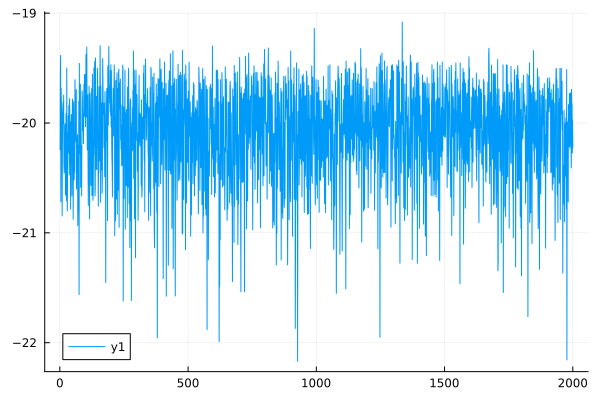

In [31]:
if TRAINING
    plot(episode_test_reward_hook.rewards)
end

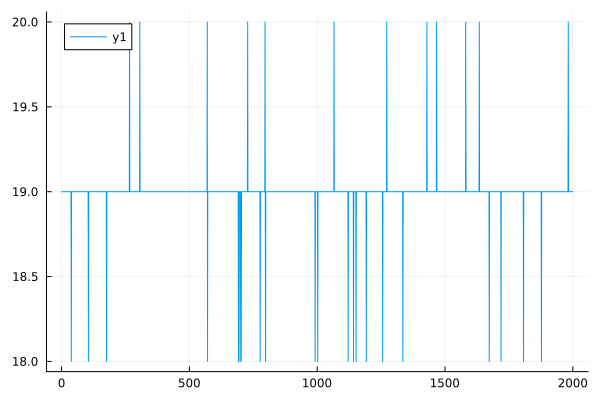

In [32]:
if TRAINING
    plot(episode_test_step_hook.steps[1:2:end])
end

In [33]:
close_visualization(); # closes the MeshCat visualization